In [29]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline
plt.rcParams.update({'font.size': 18})
sns.set_style('whitegrid')

In [2]:
IMG_DIR = 'report/img'
def save_pic(name):
    plt.tight_layout()
    plt.savefig(os.path.join(IMG_DIR, name))

In [3]:
interesting_columns = ['person_id', 'person_name', 'year', 'office_id',
           'office_name', 'income_personal', 'income_relatives']

In [4]:
officials_income = pd.read_csv('data/officials_income.csv')
officials_income.head()

,person_id,person_name,income
0,8,Зюганов Геннадий Андреевич,20453218.69
1,9,Алферов Жорес Иванович,81462661.75
2,10,Андреев Андрей Анатольевич,14475607.50
3,12,Афонин Юрий Вячеславович,23774458.69
4,13,Гаврилов Сергей Анатольевич,19608057.29


In [5]:
officials_income.shape

(49032, 3)

In [392]:
outliers = officials_income[
    (
        officials_income.income < officials_income.income.mean() - 3 * officials_income.income.std() 
    ) 
    |
    (
        officials_income.income > officials_income.income.mean() + 3 * officials_income.income.std()
    )
]
print(outliers.shape)
outliers.sort_values(by='income').head(10)

(199, 3)


,person_id,person_name,income
517,617,Гаджиев Мурад Станиславович,2.163306e+08
9903,12360,Клет Вадим Михайлович,2.174238e+08
10814,13275,Усс Александр Викторович,2.178213e+08
10501,12960,Мещеряков Николай Иосифович,2.193501e+08
5327,7661,Ливинский Павел Анатольевич,2.216612e+08
267,334,Ильковский Константин Константинович,2.243715e+08
10546,13005,Зубарев Игорь Дмитриевич,2.260637e+08
379,459,Володин Вячеслав Викторович,2.262342e+08
11504,13967,Тощев Федор Викторович,2.274549e+08
13703,16181,Ельфимова Татьяна Леонидовна,2.290679e+08


In [393]:
declarations_df_source = pd.read_csv('data/declarations.csv')
declarations_df_source.head()

,person_id,person_name,year,office_id,office_name,office_type_id,office_type_name,office_region_id,office_region_name,income_personal,income_relatives,savings,real_estate_amount,real_estate_squares
0,8,Зюганов Геннадий Андреевич,2009,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2075542.33,102279.19,0.00,3,448.7
1,8,Зюганов Геннадий Андреевич,2010,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2126487.00,0.00,3126451.00,1,167.4
2,8,Зюганов Геннадий Андреевич,2010,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2127686.49,168601.94,0.00,3,448.7
3,8,Зюганов Геннадий Андреевич,2010,449,Президент Российской Федерации,7,"Федеральный, без региональной структуры",NaN,NaN,7681748.38,349885.97,4343156.26,2,281.3
4,8,Зюганов Геннадий Андреевич,2011,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2177566.64,137656.24,0.00,3,448.7


In [394]:
print('Unique persons', declarations_df_source.person_id.unique().shape[0])
print('Unique offices', declarations_df_source.office_id.unique().shape[0])
print('Unique offices', declarations_df_source.office_region_id.unique().shape[0])

Unique persons 51855
Unique offices 2104
Unique offices 86


In [395]:
declarations_df_source.shape

(90397, 14)

Remove outliers

In [396]:
declarations_df = declarations_df_source.copy()

In [397]:
declarations_df = declarations_df_source[~declarations_df_source.person_id.isin(outliers.person_id)]
declarations_df['income'] = declarations_df_source['income_personal'] + declarations_df_source['income_relatives']
declarations_df = declarations_df[~(
    (
        declarations_df.income < declarations_df.income.mean() - 3 * declarations_df.income.std() 
    ) 
    |
    (
        declarations_df.income > declarations_df.income.mean() + 3 * declarations_df.income.std()
    )
)]
declarations_df.shape

/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(89508, 15)

In [398]:
declarations_df.sample(5)

,person_id,person_name,year,office_id,office_name,office_type_id,office_type_name,office_region_id,office_region_name,income_personal,income_relatives,savings,real_estate_amount,real_estate_squares,income
55939,26695,Ветохин Павел Сергеевич,2015,767,Приморский краевой суд,18,"Региональный, без структуры",74.0,Приморский край,2574803.50,0.00,0.0,8,1591.20,2574803.50
43872,19831,Богданчиков Анатолий Борисович,2011,20,Прокуратура Алтайского края,18,"Региональный, без структуры",24.0,Алтайский край,1227164.00,388396.00,0.0,6,3441.00,1615560.00
46177,21017,Максименков Сергей Владимирович,2015,1397,Калининград - городской округ,20,"Муниципальный, без структуры",46.0,Калининградская область,195000.00,108000.00,0.0,2,814.00,303000.00
89894,51918,Федорова Наталия Анатольевна,2016,1155,Администрация Красногвардейского района,21,"Организация, без структуры",1.0,Санкт-Петербург,1346968.84,359824.17,0.0,4,1843.18,1706793.01
78421,42037,Овсянников Евгений Викторович,2016,612,Центральный Банк,7,"Федеральный, без региональной структуры",NaN,NaN,8205259.88,1765075.21,0.0,12,2941.30,9970335.09


In [399]:
declarations_df.shape

(89508, 15)

In [400]:
declarations_df['office_name_sep'] = declarations_df.office_name.apply(lambda x: x.replace(' ', '\n')) # For plotting

In [401]:
office_names = declarations_df[['office_id', 'office_name']].drop_duplicates().reset_index(drop=True)
office_names.index = office_names.office_id
office_names = office_names.drop(['office_id'], axis=1)
office_names

,office_name
office_id,
14,Государственная Дума
449,Президент Российской Федерации
118,Государственное собрание – Курултай Республик...
267,Законодательное собрание Алтайского края
211,Губернатор Иркутской области
1575,Новосибирск - городской округ
258,Мэр города Москвы
5,Совет Федерации
15,Счетная палата


In [402]:
office_names_sep = declarations_df[['office_id', 'office_name_sep']].drop_duplicates().reset_index(drop=True)
office_names_sep.index = office_names_sep.office_id
office_names_sep = office_names_sep.drop(['office_id'], axis=1)
office_names_sep

,office_name_sep
office_id,
14,Государственная\nДума
449,Президент\nРоссийской\nФедерации
118,Государственное\n\nсобрание\n–\nКурултай\nРесп...
267,Законодательное\nсобрание\nАлтайского\nкрая
211,Губернатор\nИркутской\nобласти
1575,Новосибирск\n-\nгородской\nокруг
258,Мэр\nгорода\nМосквы
5,Совет\nФедерации
15,Счетная\nпалата


# Plan
## Meta
* Total declarations
* Declarations by year
* Declarations by office
* Office types

## Basic info 
* Total people
* Total offices
* People distribution by years
* People distribution by office
* People distribution by years by office

## Declared assets
* Income, distributions
    * By year
* Richest people by year
    * Top 10 richest people in each year
* Median incomes by office
* Income vs years worked


# Meta

In [403]:
print(declarations_df.shape)

(89508, 16)


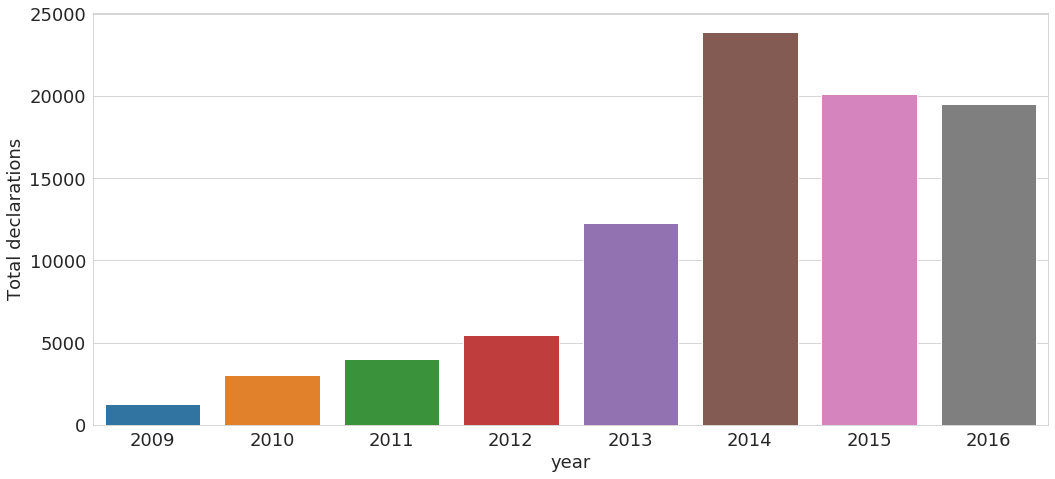

In [404]:
dec_count = declarations_df.groupby(['year'])['person_id'].count()
plt.figure(figsize=(15, 7))
sns.barplot(dec_count.index, dec_count)
plt.ylabel('Total declarations')
save_pic('total_dec')
plt.show()

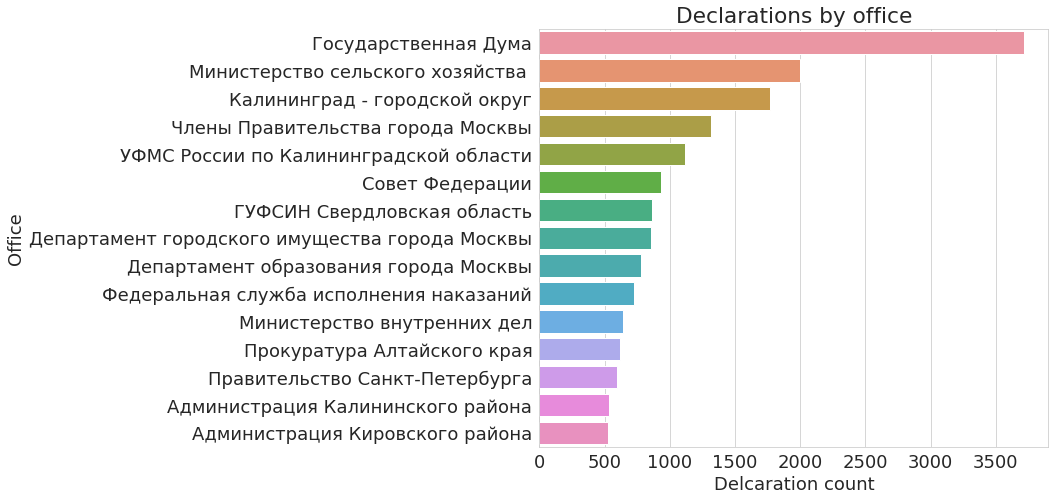

In [405]:
dec_count = declarations_df.groupby(['office_name'])['person_id'].count().sort_values(ascending=False).head(15)
plt.figure(figsize=(15, 7))
sns.barplot(dec_count, dec_count.index)
plt.ylabel('Office')
plt.xlabel('Delcaration count')
save_pic('dec_by_office')
plt.title('Declarations by office')
plt.show()

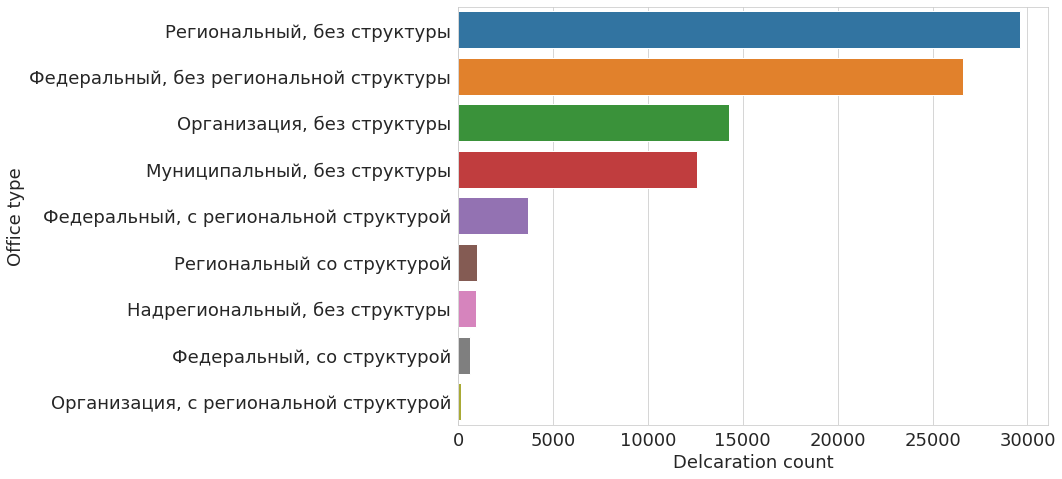

In [406]:
dec_count = declarations_df.groupby(['office_type_name'])['person_id'].count().sort_values(ascending=False)
plt.figure(figsize=(15, 7))
sns.barplot(dec_count, dec_count.index)
plt.ylabel('Office type')
plt.xlabel('Delcaration count')
save_pic('dec_by_office_type')
# plt.title('Declarations by office type')
plt.show()

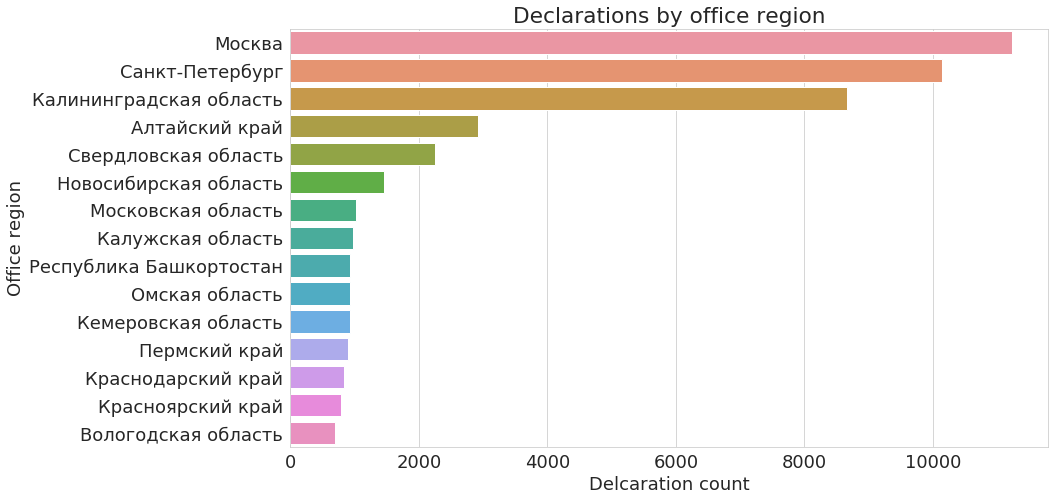

In [407]:
dec_count = declarations_df.groupby(['office_region_name'])['person_id'].count().sort_values(ascending=False).head(15)
plt.figure(figsize=(15, 7))
sns.barplot(dec_count, dec_count.index)
plt.ylabel('Office region')
plt.xlabel('Delcaration count')
save_pic('dec_by_office_region')
plt.title('Declarations by office region')
plt.show()

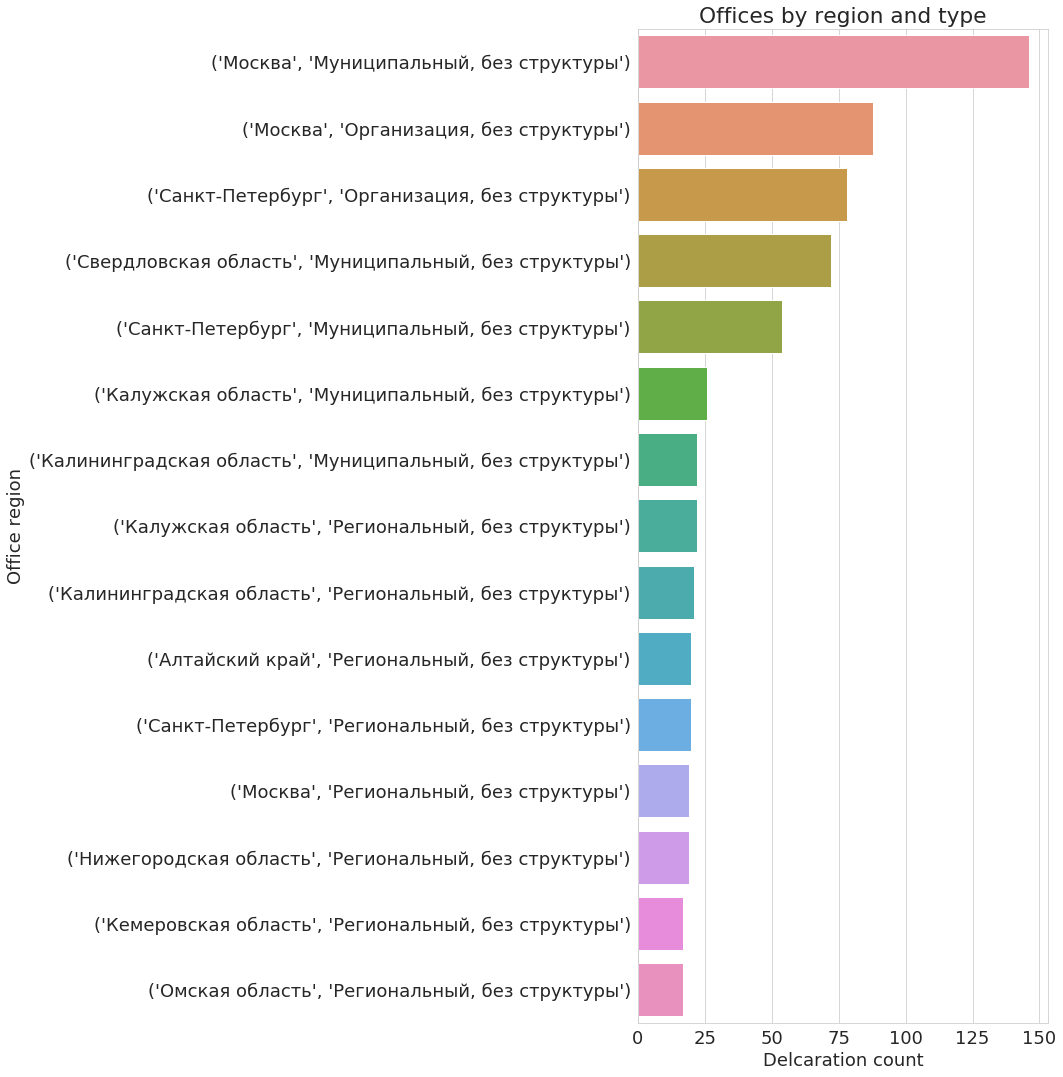

In [408]:
office_count = declarations_df.groupby([ 'office_region_name', 'office_type_name'])['office_id'].nunique().sort_values(ascending=False).head(15)
plt.figure(figsize=(15, 15))
sns.barplot(office_count, office_count.index)
plt.ylabel('Office region')
plt.xlabel('Delcaration count')
save_pic('office_by_region_and_type')
plt.title('Offices by region and type')
plt.show()

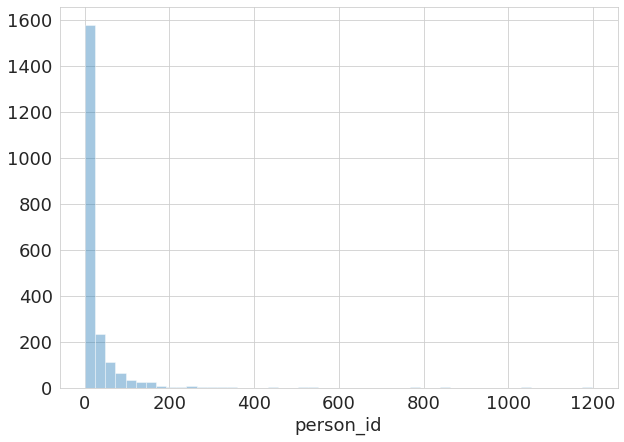

In [409]:
# people by office
people_by_office = declarations_df.groupby(['office_id'])['person_id'].nunique()
plt.figure(figsize=(10, 7))
sns.distplot(people_by_office, kde=False)
plt.show()

In [410]:
# office_count.reset_index()

In [411]:
declarations_df.head().T

,0,1,2,3,4
person_id,8,8,8,8,8
person_name,Зюганов Геннадий Андреевич,Зюганов Геннадий Андреевич,Зюганов Геннадий Андреевич,Зюганов Геннадий Андреевич,Зюганов Геннадий Андреевич
year,2009,2010,2010,2010,2011
office_id,14,14,14,449,14
office_name,Государственная Дума,Государственная Дума,Государственная Дума,Президент Российской Федерации,Государственная Дума
office_type_id,7,7,7,7,7
office_type_name,"Федеральный, без региональной структуры","Федеральный, без региональной структуры","Федеральный, без региональной структуры","Федеральный, без региональной структуры","Федеральный, без региональной структуры"
office_region_id,NaN,NaN,NaN,NaN,NaN
office_region_name,NaN,NaN,NaN,NaN,NaN
income_personal,2.07554e+06,2.12649e+06,2.12769e+06,7.68175e+06,2.17757e+06


# People distribution, offices

In [412]:
print('Unique persons', declarations_df.person_id.unique().shape[0])
print('Unique offices', declarations_df.office_id.unique().shape[0])
print('Unique offices', declarations_df.office_region_id.unique().shape[0])

Unique persons 51655
Unique offices 2098
Unique offices 86


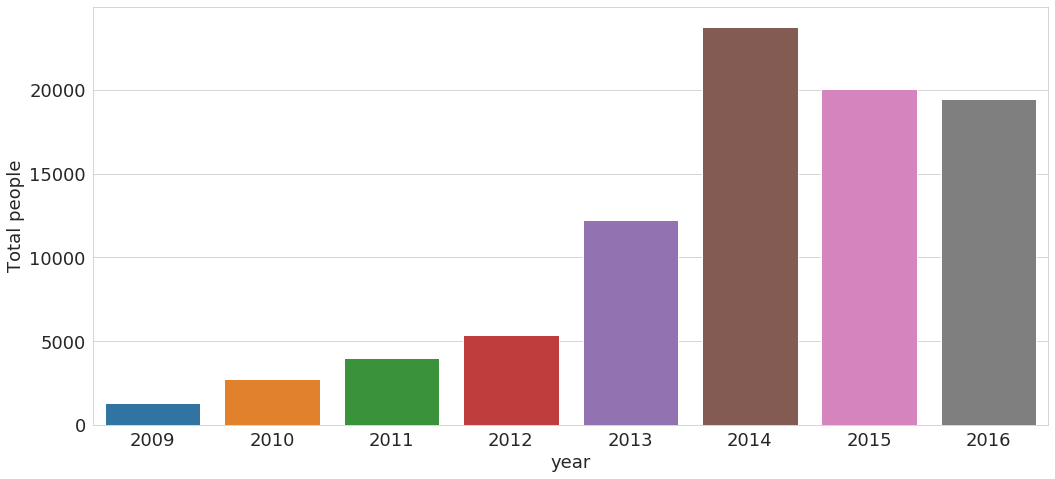

In [413]:
people_count = declarations_df.groupby(['year'])['person_id'].nunique()
plt.figure(figsize=(15, 7))
sns.barplot(people_count.index, people_count)
plt.ylabel('Total people')
save_pic('total_people')
plt.show()

Top 10 offices by unique people


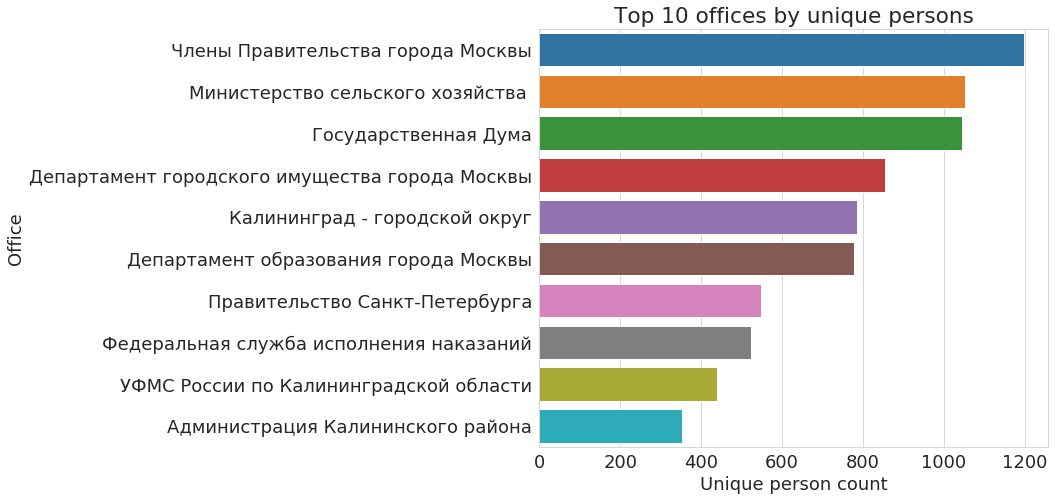

In [414]:
print('Top 10 offices by unique people')
unique_per_office = declarations_df.groupby(['office_id'])['person_id'].nunique().sort_values(ascending=False)

to_plot = unique_per_office.head(10)
plt.figure(figsize=(15, 7))
sns.barplot(y=office_names.loc[to_plot.index].values.flatten(), x=to_plot.values)
plt.ylabel('Office')
plt.xlabel('Unique person count')
save_pic('unique_by_office')
plt.title('Top 10 offices by unique persons')
plt.show()

People per year per office


/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


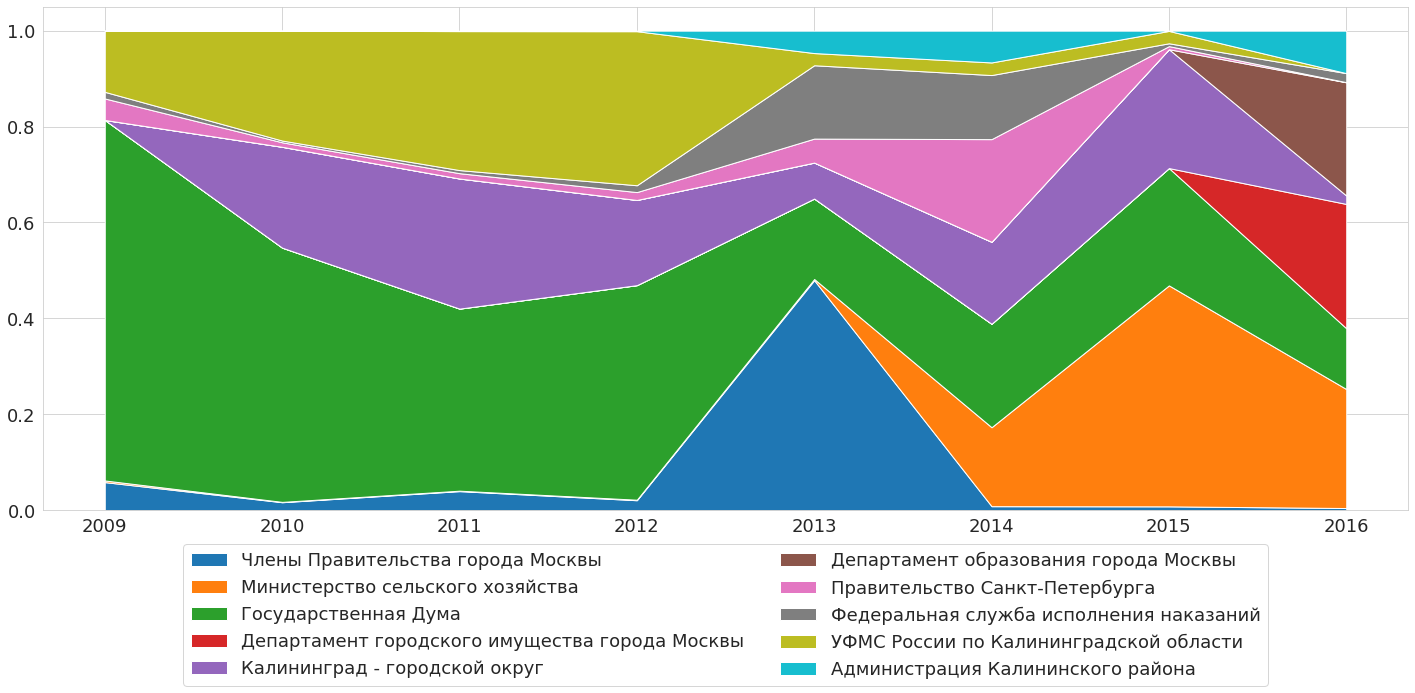

In [415]:
print('People per year per office')

years=sorted(declarations_df.year.unique())

top_offices = np.array(unique_per_office.head(10).index)


grouped = declarations_df.groupby(['office_id', 'year'])['person_id'].nunique()
grouped.head()
y = []
for office in top_offices:
    vals = grouped[office]
    vals = vals.reindex(years, fill_value=0)
    vals.name = office
    y.append(vals)
    
y = pd.DataFrame(y).T
y = y.divide(y.sum(axis=1), axis=0)
labels = office_names.ix[top_offices].values.flatten()
plt.figure(figsize=(20, 10))
plt.stackplot(years,y.T.values, labels=labels)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
save_pic('unique_by_year_by_office')
plt.show()

People per year per office


/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


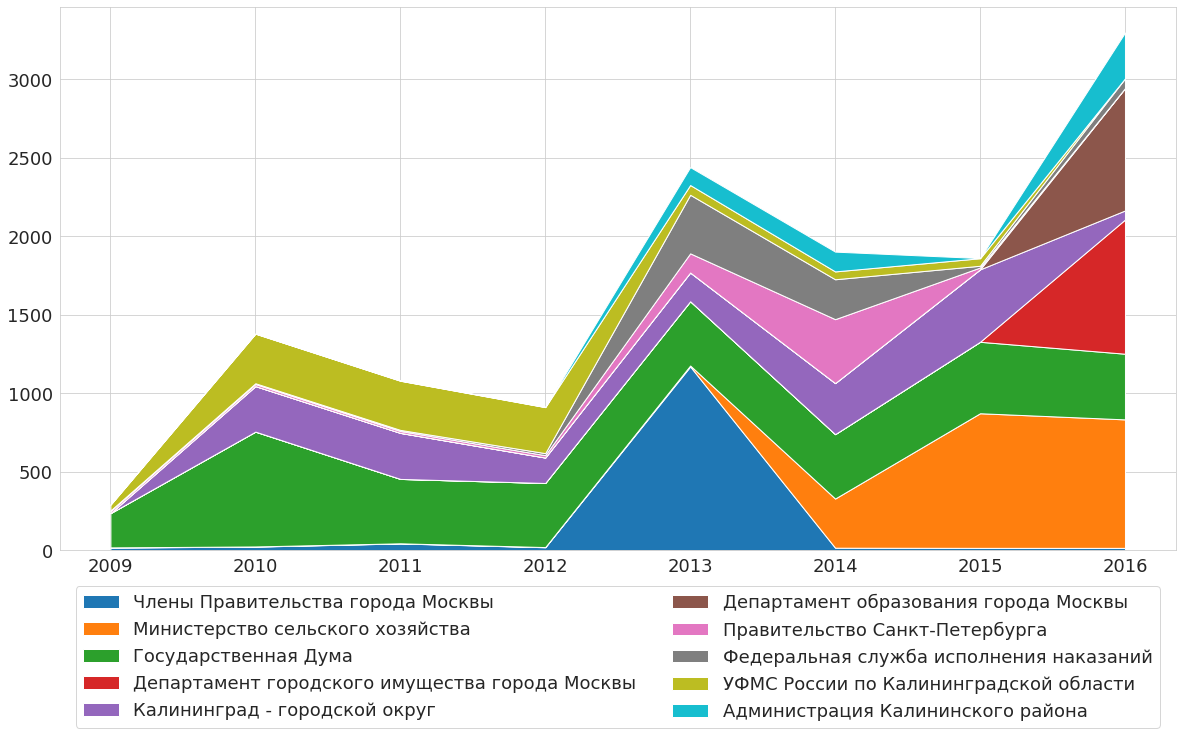

In [416]:
print('People per year per office')

years=sorted(declarations_df.year.unique())

top_offices = np.array(unique_per_office.head(10).index)


grouped = declarations_df.groupby(['office_id', 'year'])['person_id'].nunique()
grouped.head()
y = []
for office in top_offices:
    vals = grouped[office]
    vals = vals.reindex(years, fill_value=0)
    vals.name = office
    y.append(vals)
    
y = pd.DataFrame(y).T
labels = office_names.ix[top_offices].values.flatten()
plt.figure(figsize=(20, 10))
plt.stackplot(years,y.T, labels=labels)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()

/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


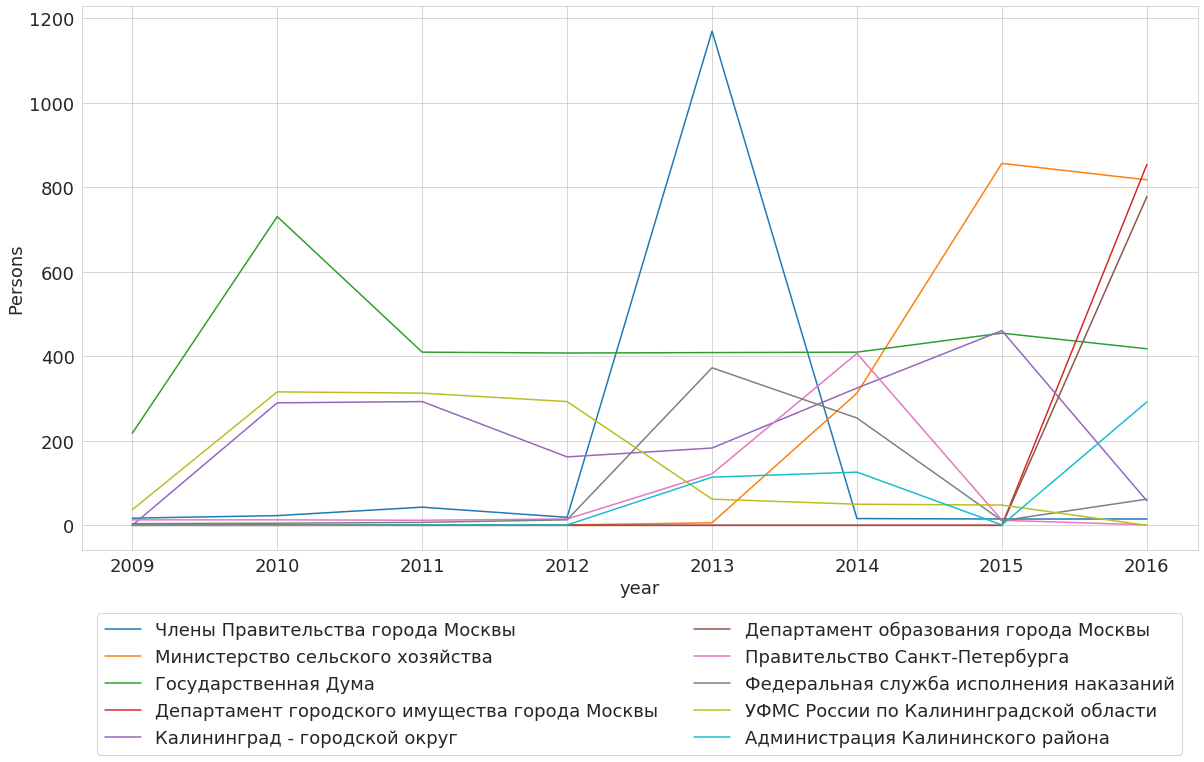

In [417]:
plt.figure(figsize=(20, 10))
for office in top_offices[:10]:
    sns.lineplot(y.index, y[office], label=office_names.ix[office].office_name)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.ylabel('Persons')
plt.show()

In [418]:
# Переходы из учреждения в учреждение?

In [419]:
grouped[979]

year
2009      17
2010      23
2011      43
2012      19
2013    1170
2014      16
2015      15
2016      15
Name: person_id, dtype: int64

In [420]:
declarations_df.sort_values(by=['person_id', 'year']).groupby(['person_id'])[['year', 'office_id']].apply(list)

person_id
8        [year, office_id]
9        [year, office_id]
10       [year, office_id]
11       [year, office_id]
12       [year, office_id]
               ...        
52414    [year, office_id]
52415    [year, office_id]
52416    [year, office_id]
52417    [year, office_id]
52418    [year, office_id]
Length: 51655, dtype: object

In [421]:
prev_workplaces = declarations_df[['person_id', 'year', 'office_id']].merge(declarations_df[['person_id', 'year', 'office_id']],  on='person_id', suffixes=('_cur', '_prev'))

prev_workplaces.head()

,person_id,year_cur,office_id_cur,year_prev,office_id_prev
0,8,2009,14,2009,14
1,8,2009,14,2010,14
2,8,2009,14,2010,14
3,8,2009,14,2010,449
4,8,2009,14,2011,14


In [422]:
transitions = prev_workplaces[((prev_workplaces.year_cur - prev_workplaces.year_prev) == 1)
                &
                (prev_workplaces.office_id_cur != prev_workplaces.office_id_prev)].drop_duplicates()

transition_tuples = transitions[['year_cur', 'office_id_prev', 'office_id_cur']]
transition_tuples.head()

,year_cur,office_id_prev,office_id_cur
30,2010,14,449
43,2011,449,14
323,2012,14,118
335,2013,118,14
522,2011,14,267


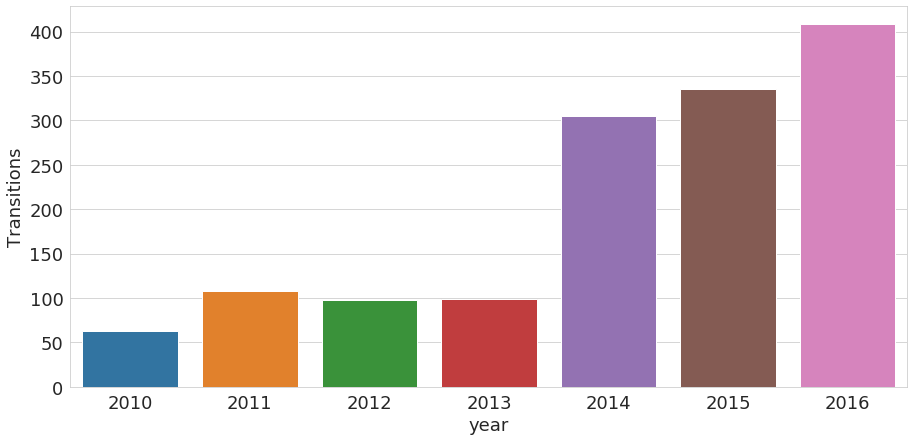

In [423]:
plt.figure(figsize=(15, 7))
sns.countplot(x=transition_tuples.year_cur)
plt.ylabel('Transitions')
plt.xlabel('year')
plt.show()

In [424]:
transitions_per_year = transition_tuples.groupby(['year_cur', 'office_id_prev', 'office_id_cur']).count().sort_values(by=['year_cur', 'office_id_prev'], ascending=False).reset_index()
year_graphs = {}
for year_cur in transitions_per_year.year_cur.unique():
    transitions_this_year = transitions_per_year[transitions_per_year.year_cur == year_cur]
    year_graphs[year_cur] = transitions_this_year[['office_id_prev', 'office_id_cur']].values
    print(transitions_this_year.head())

   year_cur  office_id_prev  office_id_cur
0      2016            6654            539
1      2016            6616            924
2      2016            6121            113
3      2016            5960            584
4      2016            5356           4744
     year_cur  office_id_prev  office_id_cur
326      2015            6387            950
327      2015            6382            533
328      2015            6371            528
329      2015            6370            448
330      2015            6343           1420
     year_cur  office_id_prev  office_id_cur
621      2014            6670            482
622      2014            6669            482
623      2014            6668            482
624      2014            6667            482
625      2014            6519            482
     year_cur  office_id_prev  office_id_cur
813      2013            5958            978
814      2013            5958            979
815      2013            5955            979
816      2013         

In [425]:
transition_tuples.head()

,year_cur,office_id_prev,office_id_cur
30,2010,14,449
43,2011,449,14
323,2012,14,118
335,2013,118,14
522,2011,14,267


In [426]:
transition_tuples.shape

(1416, 3)

In [427]:
year_graphs = {}
for year_cur in transitions_per_year.year_cur.unique():
    
    year_transitions = transition_tuples[transition_tuples.year_cur == year_cur][['office_id_prev', 'office_id_cur']]
    counts = year_transitions.groupby(['office_id_prev', 'office_id_cur'])['office_id_cur'].count()
    unique_transitions = year_transitions.drop_duplicates().copy()
    unique_transitions['count'] = unique_transitions.apply(lambda row: counts[row.office_id_prev][row.office_id_cur], axis=1)
    year_graphs[year_cur] = unique_transitions.copy()

In [428]:
import networkx as nx

In [429]:
office_names_dict = {k: v['office_name'] for k, v in office_names.to_dict(orient='index').items()}

In [430]:
office_names_dict[118]

'Государственное  собрание – Курултай Республики Башкортостан'

/home/boris/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/boris/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


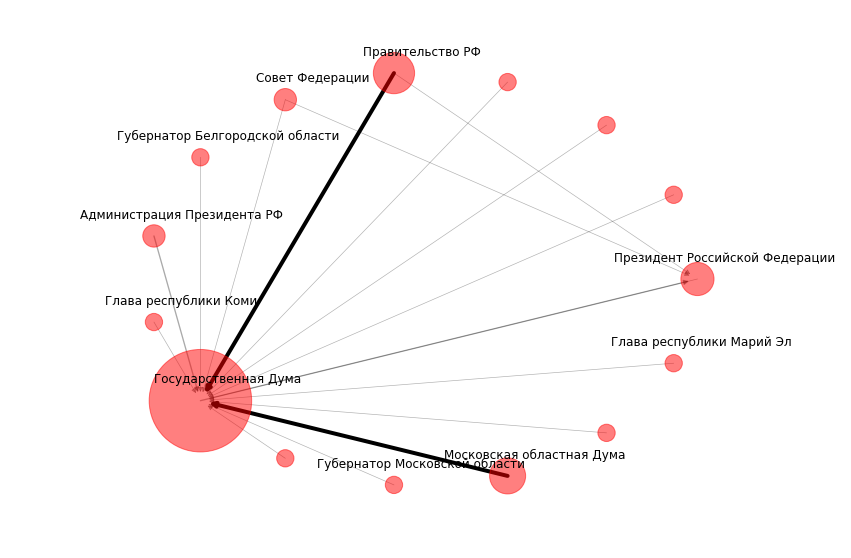

In [431]:
def draw_graph(graph, labels):
    plt.figure(figsize=(15, 10))
    
#     pos = nx.spring_layout(graph, k=3 * 1/np.sqrt(len(graph.nodes())))
    degree_centrality = dict(graph.degree(weight='weight'))# nx.degree_centrality(graph)
    degree_centrality = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['centrality'])
    degree_centrality = degree_centrality.centrality
    
    graph = graph.subgraph(degree_centrality.nlargest(15).index)
    pos = nx.circular_layout(graph)
    
    #edges
    edgelist= graph.edges()
    weights = nx.get_edge_attributes(graph, 'weight')
    weights_arr = np.array([weights[e] for e in edgelist])
    weights_normed = weights_arr/weights_arr.max()

    edges = nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(),
                       width=weights_normed*4)
    
    for i, edge in enumerate(edgelist):
        edges[i].set_alpha(max(weights_normed[i], 0.3))
        
    #nodes
    node_sizes = [(200*degree_centrality[n]+100) for n in graph.nodes()]
    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, arrowstyle='->',alpha=0.5)
    

    #labels
    pos_higher = {}
    x_off = 0.1
    y_off = 0.1  # offset on the y axis

    for k, v in pos.items():
        pos_higher[k] = (v[0]+0.1, v[1]+y_off)

    node_labels = {n: (labels[n] if n in degree_centrality.nlargest(10).index else '') for n in graph.nodes()}
    nx.draw_networkx_labels(graph, pos_higher, labels=node_labels, )
    
#     weights_sorted = pd.DataFrame.from_dict(weights, orient='index', columns=['weight']).weight.sort_values(ascending=False)
#     edge_labels = {e: weights[e] for e in edgelist if e in weights_sorted[:5].index}
#     nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.axis('off')
    plt.margins(0.2, 0.1)
    plt.show()

year = 2010

graph = nx.DiGraph()
for row in year_graphs[year].itertuples():
    graph.add_edge(row.office_id_prev, row.office_id_cur, weight=row.count)

draw_graph(graph, labels=office_names_dict)

/home/boris/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/boris/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


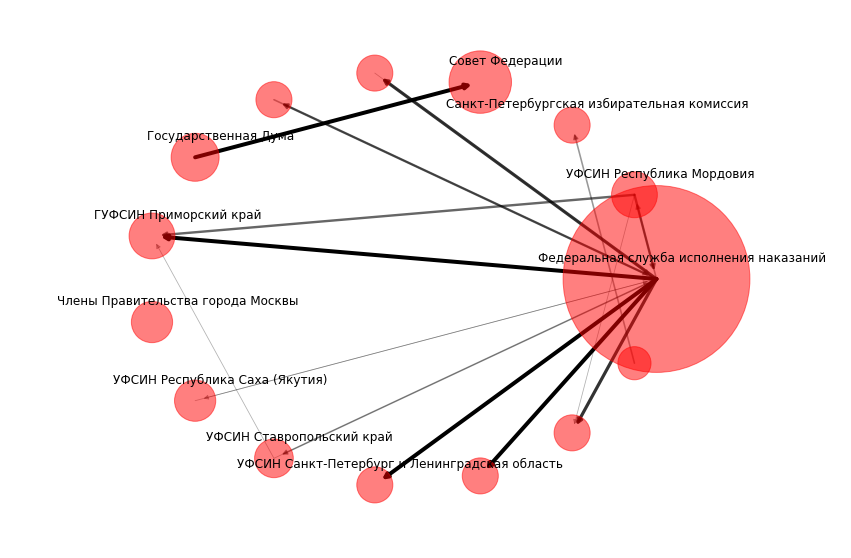

In [432]:
year = 2014

graph = nx.DiGraph()
for row in year_graphs[year].itertuples():
    graph.add_edge(row.office_id_prev, row.office_id_cur, weight=row.count)

draw_graph(graph, labels=office_names_dict)

/home/boris/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/boris/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


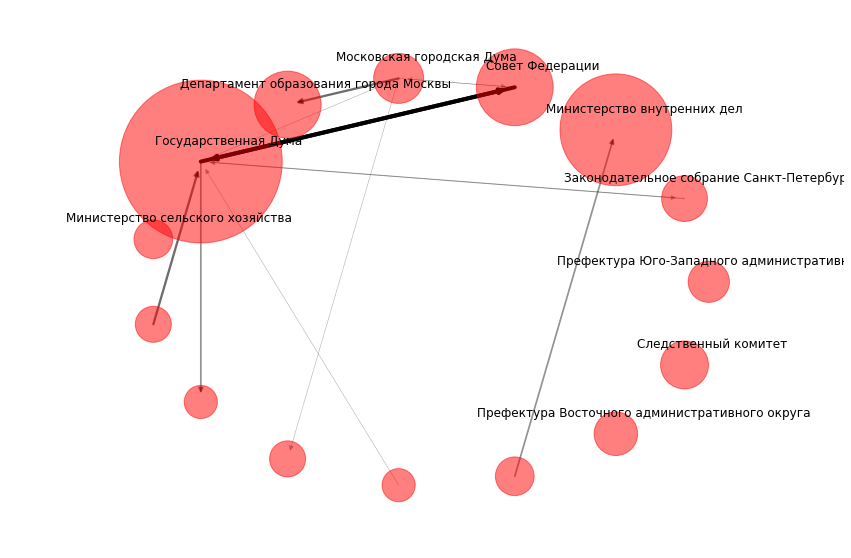

In [433]:
year = 2016

graph = nx.DiGraph()
for row in year_graphs[year].itertuples():
    graph.add_edge(row.office_id_prev, row.office_id_cur, weight=row.count)

draw_graph(graph, labels=office_names_dict)

# Declared assets

In [434]:
declarations_df.income_personal

0        2075542.33
1        2126487.00
2        2127686.49
3        7681748.38
4        2177566.64
            ...    
90392     912171.66
90393     875869.53
90394    5153430.55
90395    3100832.87
90396    4097215.76
Name: income_personal, Length: 89508, dtype: float64

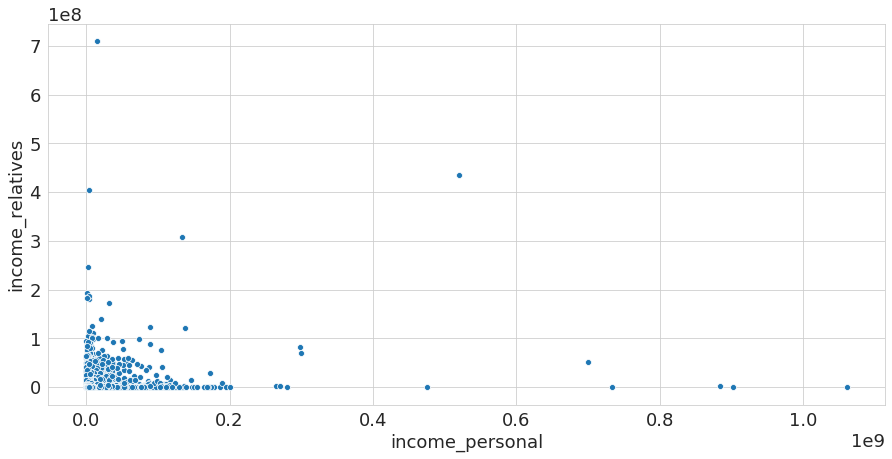

In [435]:
plt.figure(figsize=(15, 7))
sns.scatterplot(declarations_df['income_personal'], declarations_df['income_relatives'])
plt.show()

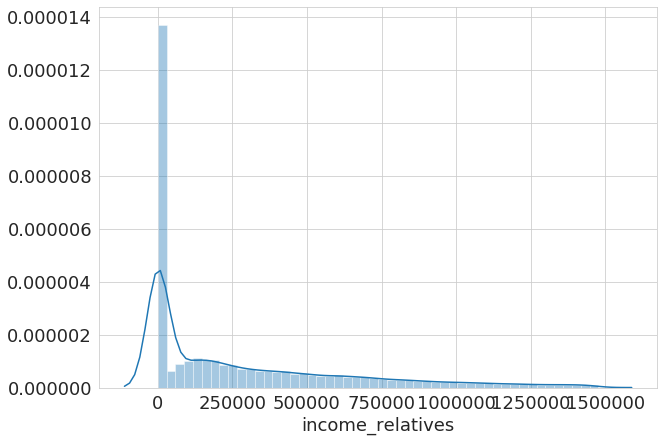

In [450]:
def no(s, q=0.9):
    return s[s < s.quantile(q)]

plt.figure(figsize=(10, 7))
sns.distplot(no(declarations_df['income_relatives']))
plt.show()

In [442]:
declarations_df.head()

,person_id,person_name,year,office_id,office_name,office_type_id,office_type_name,office_region_id,office_region_name,income_personal,income_relatives,savings,real_estate_amount,real_estate_squares,income,office_name_sep
0,8,Зюганов Геннадий Андреевич,2009,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2075542.33,102279.19,0.00,3,448.7,2177821.52,Государственная\nДума
1,8,Зюганов Геннадий Андреевич,2010,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2126487.00,0.00,3126451.00,1,167.4,2126487.00,Государственная\nДума
2,8,Зюганов Геннадий Андреевич,2010,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2127686.49,168601.94,0.00,3,448.7,2296288.43,Государственная\nДума
3,8,Зюганов Геннадий Андреевич,2010,449,Президент Российской Федерации,7,"Федеральный, без региональной структуры",NaN,NaN,7681748.38,349885.97,4343156.26,2,281.3,8031634.35,Президент\nРоссийской\nФедерации
4,8,Зюганов Геннадий Андреевич,2011,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2177566.64,137656.24,0.00,3,448.7,2315222.88,Государственная\nДума


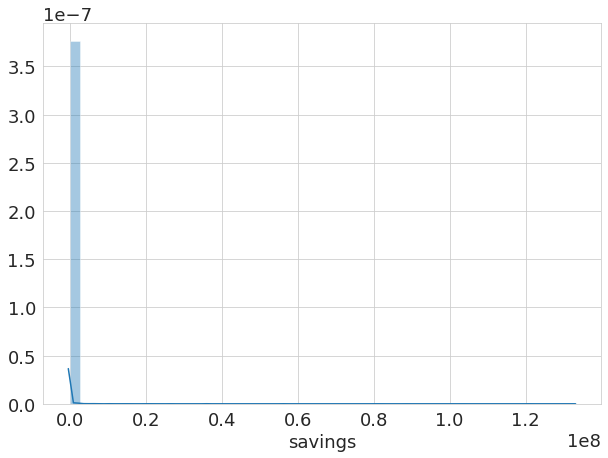

In [456]:
plt.figure(figsize=(10, 7))
sns.distplot(no(declarations_df['savings'], q=1))
plt.show()

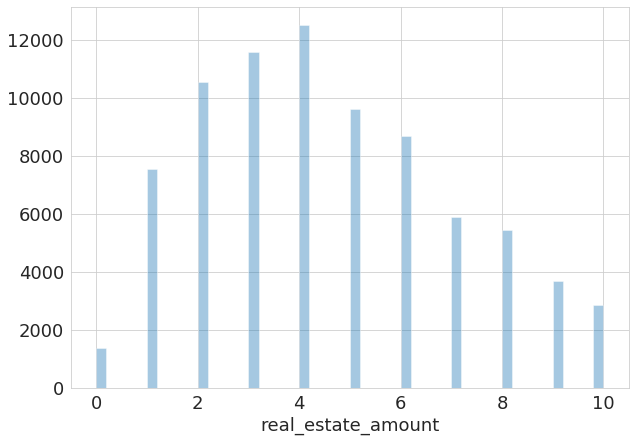

In [457]:
plt.figure(figsize=(10, 7))
sns.distplot(no(declarations_df['real_estate_amount']), kde=False)
plt.show()

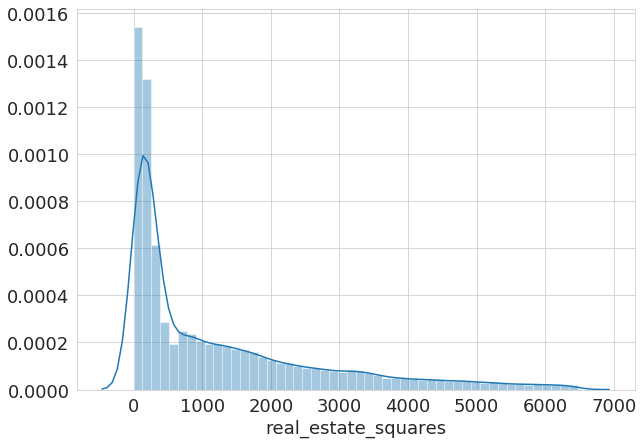

In [453]:
plt.figure(figsize=(10, 7))
sns.distplot(no(declarations_df['real_estate_squares']))
plt.show()

In [459]:
income_sum = declarations_df.groupby(['person_id'])['income'].sum()
print(income_sum.shape)
income_sum.head()

(51655,)


person_id
8     4.005369e+07
9     1.427950e+08
10    3.131614e+07
11    1.134432e+07
12    6.979880e+07
Name: income, dtype: float64

In [460]:
income_sum = income_sum.sort_values(ascending=False)

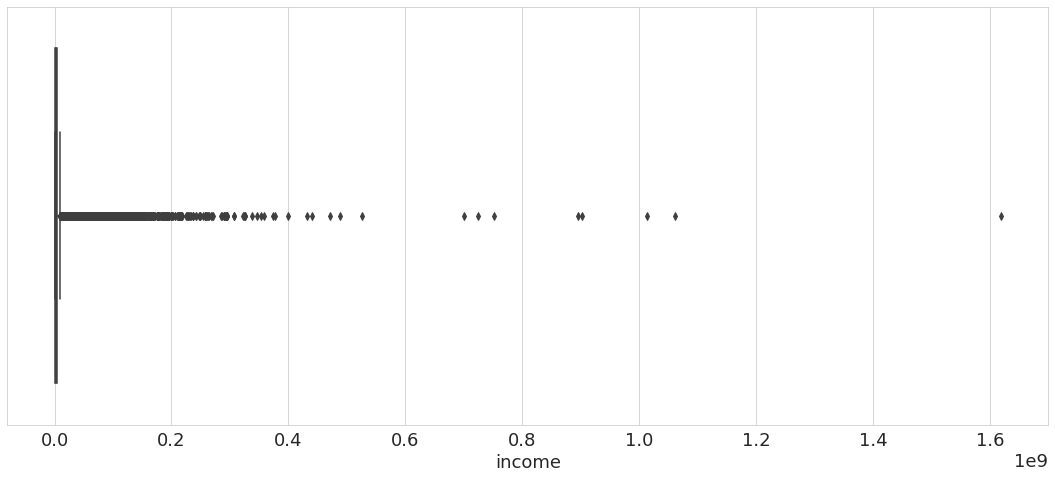

In [461]:
plt.figure(figsize=(15, 7))
sns.boxplot(income_sum)
save_pic('income_boxplot_1')
plt.show()

### Income
* Total income per year
* Median income per year
* Median income per office
* Top offices by median income, per year

In [462]:
yearly_assets_sum = declarations_df.groupby(['year']).sum()
yearly_assets_sum.head()

,person_id,office_id,office_type_id,office_region_id,income_personal,income_relatives,savings,real_estate_amount,real_estate_squares,income
year,,,,,,,,,,
2009,14067226,666790,17105,41500.0,4.288873e+09,1.577779e+09,3.582251e+06,6916,8.402609e+07,5.866652e+09
2010,24656943,2970451,35921,75675.0,1.052226e+10,2.713328e+09,2.712958e+09,14548,1.759952e+09,1.323559e+10
2011,37283243,4859368,57458,146325.0,1.208729e+10,4.760083e+09,5.337481e+06,20209,1.303242e+09,1.684737e+10
2012,49056280,6518062,82850,197834.0,1.702956e+10,7.224139e+09,1.117084e+08,27990,5.304128e+08,2.425370e+10
2013,222407717,23181927,167337,404751.0,2.834164e+10,8.944509e+09,3.647800e+04,62540,1.018813e+09,3.728615e+10


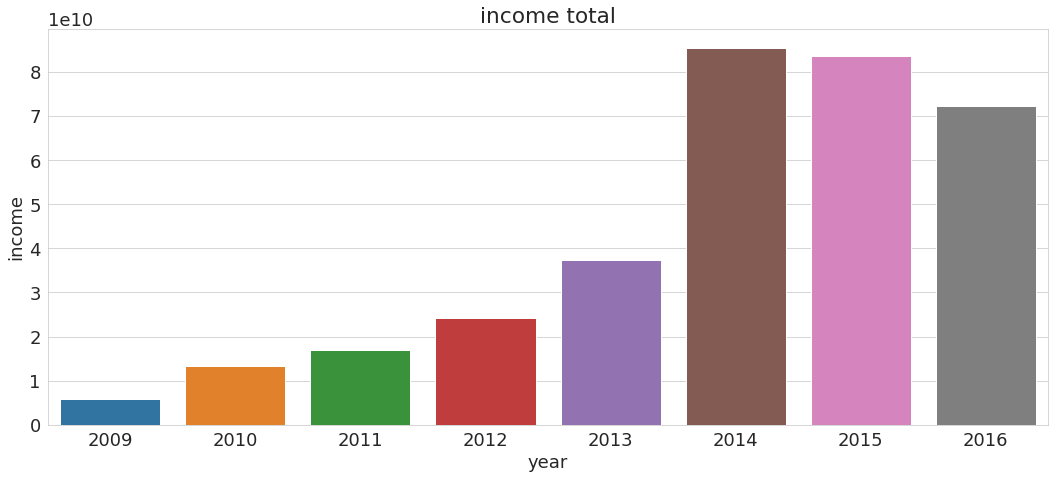

In [464]:
plt.figure(figsize=(15, 7))
plt.title('income total')
sns.barplot(yearly_assets_sum.index, yearly_assets_sum.income)
save_pic('income_by_years')
plt.show()

In [465]:
yearly_assets_median = declarations_df.groupby(['year']).median()
yearly_assets_median.head()

,person_id,office_id,office_type_id,office_region_id,income_personal,income_relatives,savings,real_estate_amount,real_estate_squares,income
year,,,,,,,,,,
2009,5397.0,86.0,18.0,53.0,1420437.000,157353.000,0.0,5.0,1107.7,1797700.000
2010,2986.0,115.0,7.0,46.0,1382000.000,56550.000,0.0,4.0,766.8,1672318.710
2011,3963.5,584.0,18.0,46.0,1131297.415,148796.500,0.0,4.0,741.2,1459011.095
2012,3978.5,681.0,18.0,46.0,1308921.500,138247.285,0.0,4.0,789.8,1652222.355
2013,11246.0,1157.0,18.0,46.0,1250676.510,188058.700,0.0,4.0,473.6,1622346.000


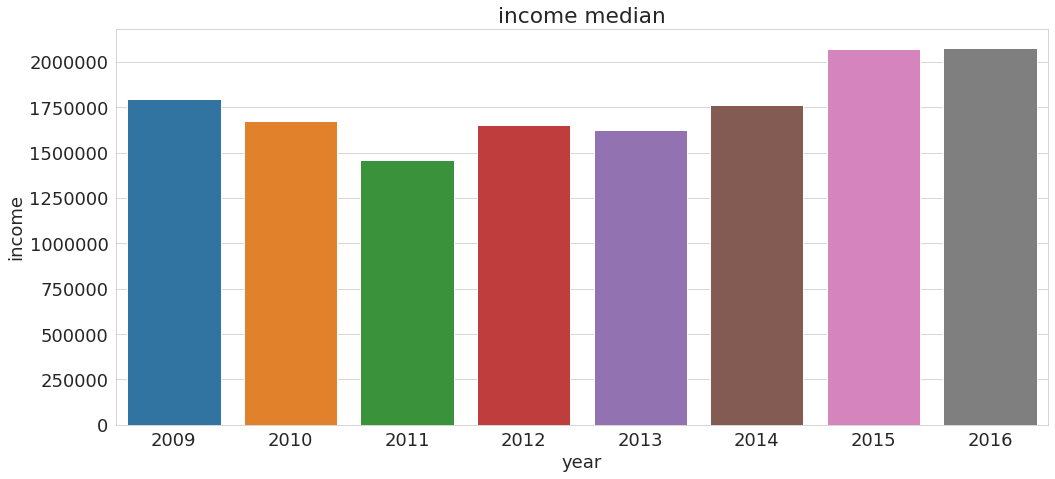

In [466]:
plt.figure(figsize=(15, 7))
plt.title('income median')
sns.barplot(yearly_assets_median.index, yearly_assets_median.income)
save_pic('income_by_years_med')
plt.show()   

In [467]:
office_people_counts = declarations_df.groupby(['office_id'])['person_id'].count().sort_values(ascending=False)
big_offices = office_people_counts[office_people_counts > office_people_counts.quantile(0.75)] # over 35 people in office 
big_offices.shape

(521,)

In [468]:
big_office_declarations = declarations_df[declarations_df.office_id.isin(big_offices.index)]
print(big_office_declarations.shape)
big_office_declarations.head()

(72741, 16)


,person_id,person_name,year,office_id,office_name,office_type_id,office_type_name,office_region_id,office_region_name,income_personal,income_relatives,savings,real_estate_amount,real_estate_squares,income,office_name_sep
0,8,Зюганов Геннадий Андреевич,2009,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2075542.33,102279.19,0.0,3,448.7,2177821.52,Государственная\nДума
1,8,Зюганов Геннадий Андреевич,2010,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2126487.00,0.00,3126451.0,1,167.4,2126487.00,Государственная\nДума
2,8,Зюганов Геннадий Андреевич,2010,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2127686.49,168601.94,0.0,3,448.7,2296288.43,Государственная\nДума
4,8,Зюганов Геннадий Андреевич,2011,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2177566.64,137656.24,0.0,3,448.7,2315222.88,Государственная\nДума
5,8,Зюганов Геннадий Андреевич,2012,14,Государственная Дума,7,"Федеральный, без региональной структуры",NaN,NaN,2458749.04,194266.38,0.0,3,448.7,2653015.42,Государственная\nДума


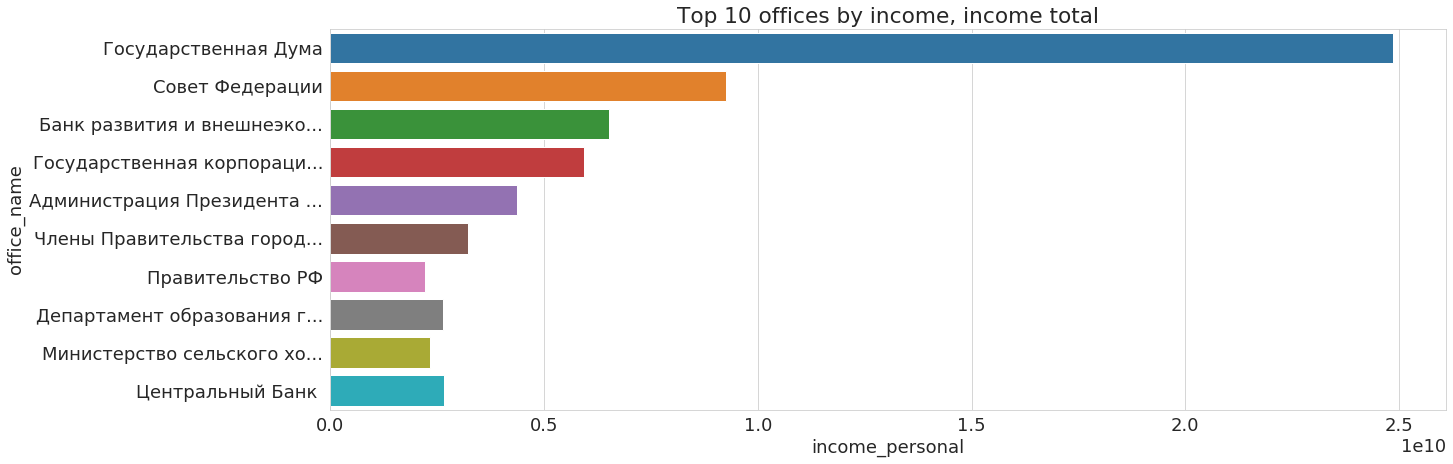

In [469]:
# Total income per office
office_assets_sum = declarations_df.groupby(['office_name']).sum().sort_values(by='income', ascending=False)
office_assets_sum.head()
to_plot = pd.DataFrame(office_assets_sum.head(10).reset_index())
to_plot['office_name'] = to_plot['office_name'].apply(lambda x: x[:25]+'...' if len(x) > 25 else x)
plt.figure(figsize=(20, 7))
plt.title('Top 10 offices by income, income total')
sns.barplot(y=to_plot.office_name, x=to_plot.income_personal)
# save_pic('office_incomes')
plt.show()

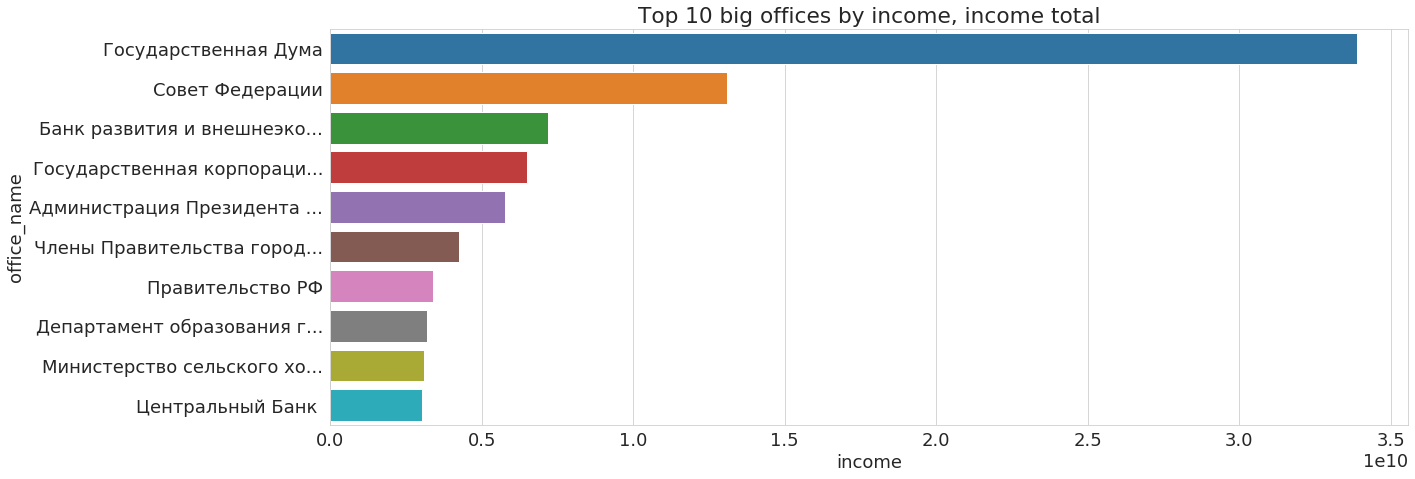

In [470]:
# Total income per office, only big offices
office_assets_sum = big_office_declarations.groupby(['office_name']).sum().sort_values(by='income', ascending=False)
to_plot = pd.DataFrame(office_assets_sum.head(10).reset_index())
to_plot['office_name'] = to_plot['office_name'].apply(lambda x: x[:25]+'...' if len(x) > 25 else x)
plt.figure(figsize=(20, 7))
plt.title('Top 10 big offices by income, income total')
sns.barplot(y=to_plot.office_name, x=to_plot.income)
save_pic('big_office_incomes')
plt.show()

In [471]:
# Median income per office
office_assets_median = big_office_declarations.groupby(['office_name']).median().sort_values(by='income', ascending=False)
office_assets_median.head()

,person_id,year,office_id,office_type_id,office_region_id,income_personal,income_relatives,savings,real_estate_amount,real_estate_squares,income
office_name,,,,,,,,,,,
Законодательное Собрание Ямало-Ненецкого автономного округа,15341.0,2015.0,954.0,18.0,104.0,18358701.77,946923.35,0.0,7.0,2117.50,1.898945e+07
Министерство финансов,11670.0,2016.0,604.0,7.0,NaN,14877587.61,8472.33,0.0,9.0,3584.80,1.576500e+07
Центральный Банк,19727.0,2016.0,612.0,7.0,NaN,14240790.00,451848.00,0.0,8.0,2531.80,1.534560e+07
"Государственная корпорация по атомной энергии ""Росатом""",38416.5,2014.0,969.0,21.0,NaN,11931694.23,341135.67,0.0,7.0,1749.65,1.295043e+07
Банк развития и внешнеэкономической деятельности (Внешэкономбанк),32299.0,2014.0,966.0,21.0,NaN,11098864.07,28800.00,0.0,7.0,1607.00,1.244712e+07


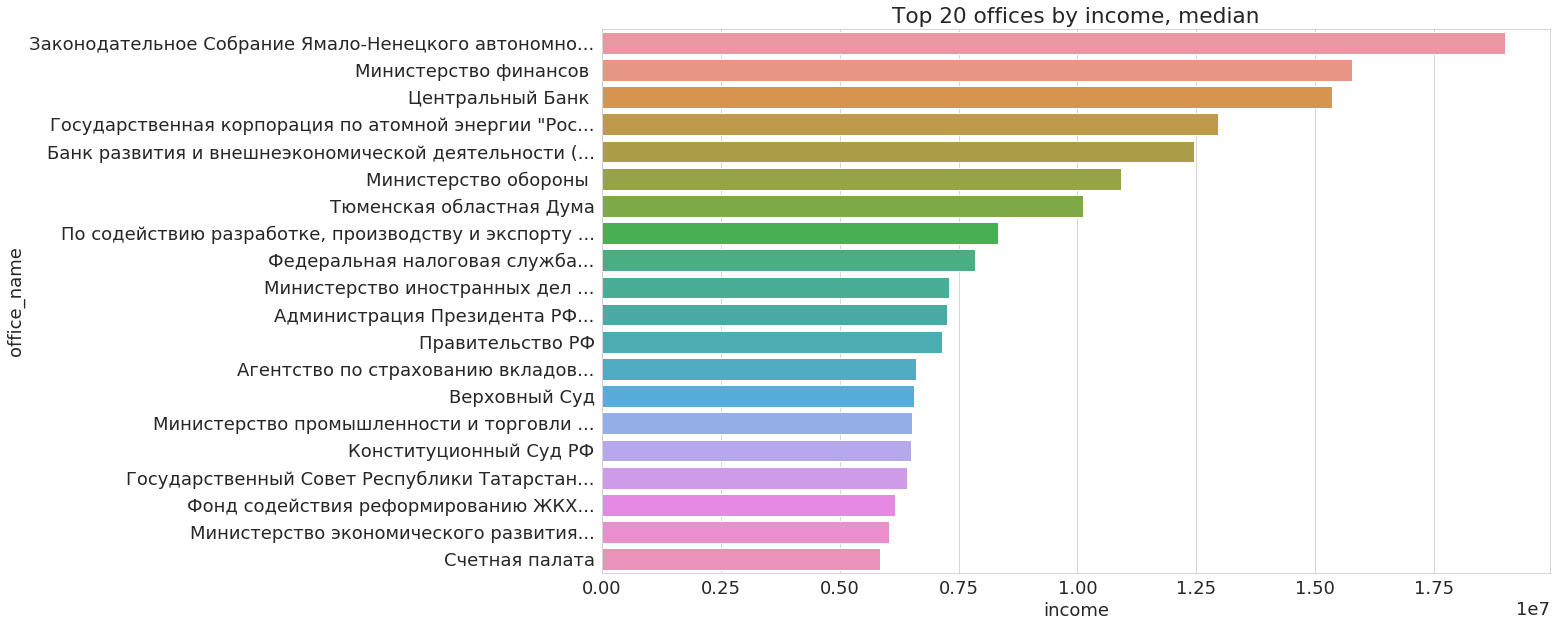

In [474]:
to_plot = office_assets_median.reset_index().head(20)
to_plot['office_name'] = to_plot.office_name.apply(lambda x: x[:50]+'...' if len(x) > 25 else x)
plt.figure(figsize=(17, 10))
plt.title('Top 20 offices by income, median')
sns.barplot(y=to_plot.office_name, x=to_plot.income)
plt.show()

Income per year per office


/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


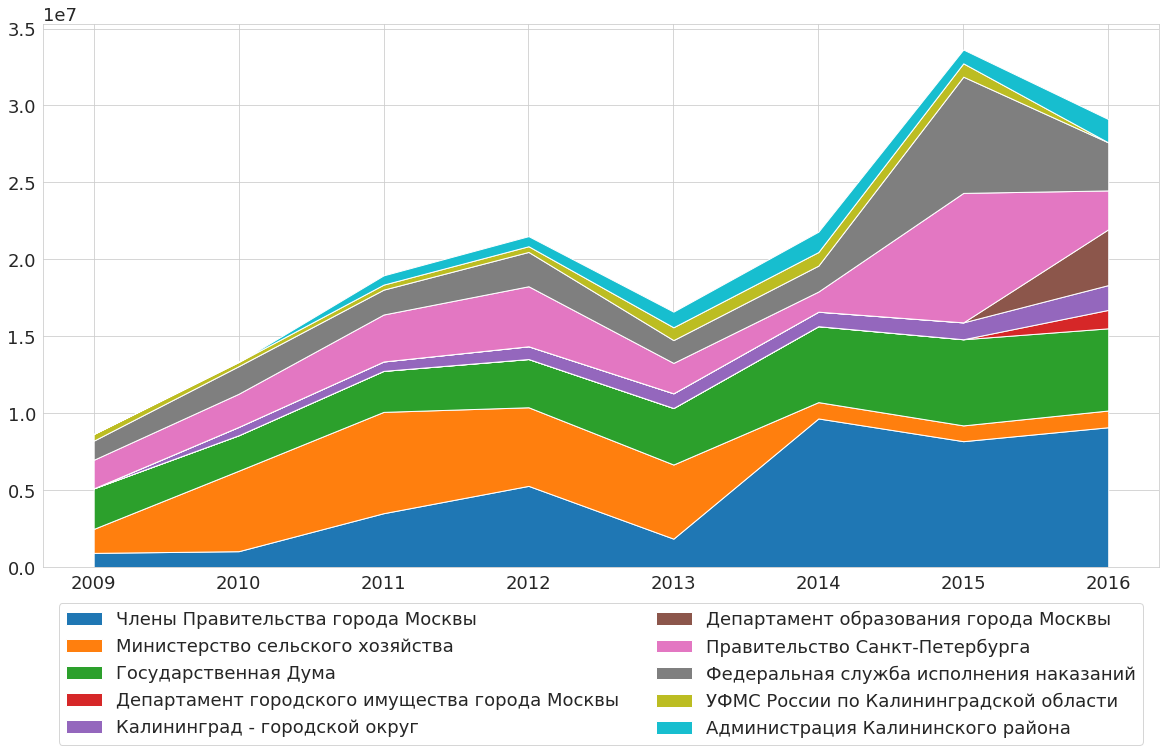

In [475]:
print('Income per year per office')

years=sorted(declarations_df.year.unique())

top_offices = np.array(unique_per_office.head(10).index)


grouped = declarations_df.groupby(['office_id', 'year'])['income'].median()
grouped.head()
# Incomes per year per office
y = []
for office in top_offices:
    vals = grouped[office]
    vals = vals.reindex(years, fill_value=0)
    vals.name = office
    y.append(vals)
    
labels = office_names.ix[top_offices].values.flatten()
plt.figure(figsize=(20, 10))
plt.stackplot(years,y, labels=labels)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()

In [478]:
grouped.head()
g = grouped.reset_index()
g = g[g.office_id.isin(top_offices)]
g['office_name'] = office_names.ix[g.office_id].values.flatten()
g.head()

/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


,office_id,year,income,office_name
56,14,2009,2633822.17,Государственная Дума
57,14,2010,2302956.73,Государственная Дума
58,14,2011,2663633.29,Государственная Дума
59,14,2012,3134921.70,Государственная Дума
60,14,2013,3671954.19,Государственная Дума


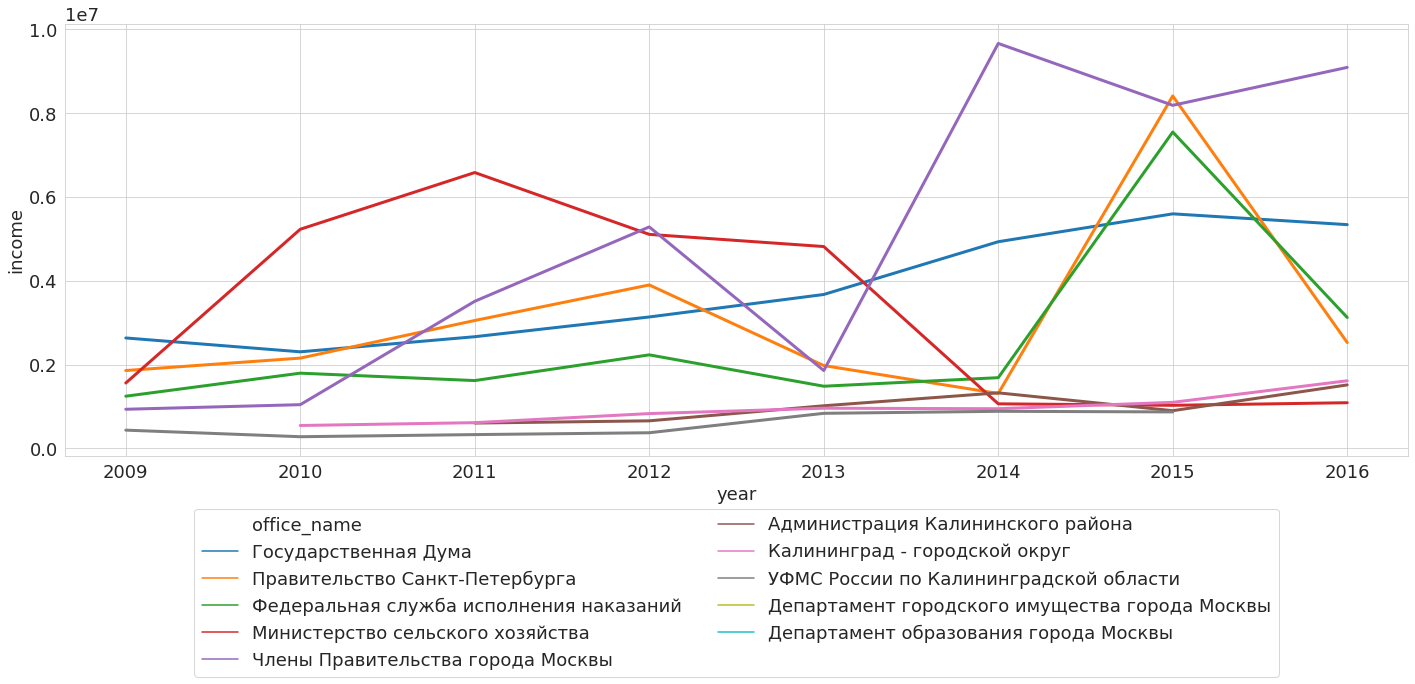

In [479]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='year', y='income', hue='office_name', data=g, lw=3, markers=True, estimator=None)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
save_pic('income_by_year_by_office_med')
plt.show()

In [480]:
# Median income per office in 2016
# office_assets_median = big_office_declarations[big_office_declarations.year == 2016].groupby(['office_name']).median().sort_values(by='income', ascending=False)
# office_assets_median.head()
# to_plot = office_assets_median.head(10)
# plt.figure(figsize=(20, 7))
# plt.title('Top 10 offices by income, median, 2016')
# sns.barplot(to_plot.index, to_plot.income)
# plt.show()

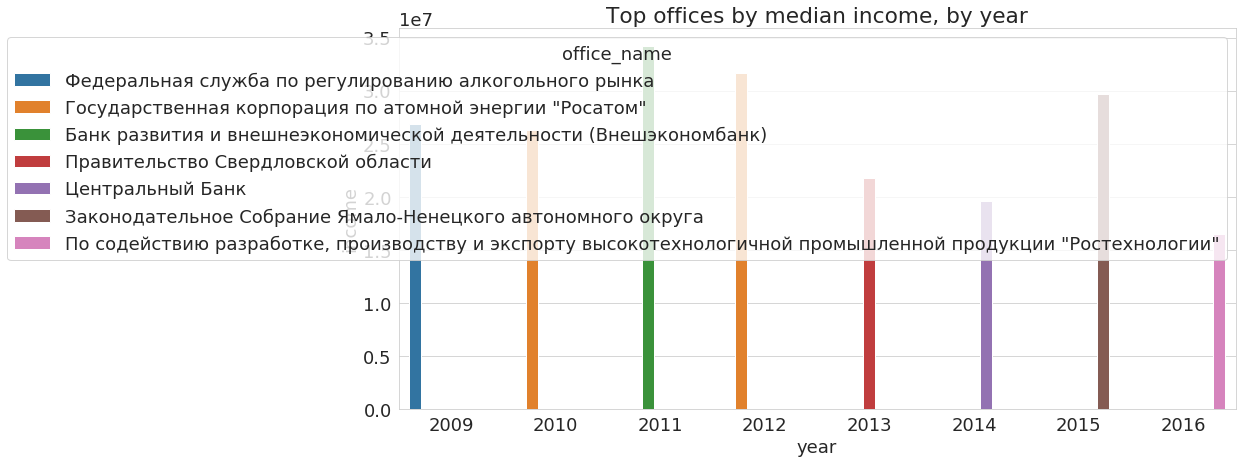

In [481]:
# Top offices by median income, by year
tdf= big_office_declarations.groupby(['year', 'office_name'])['income'].median().reset_index()
tdf2 = tdf.groupby('year')['income'].max().reset_index()
tdf_final = tdf.merge(tdf2, on=['year', 'income'], how='inner')
tdf_final.office_name = tdf_final.office_name.apply(lambda x: x.replace('\n', ' '))
plt.figure(figsize=(15,7))
plt.title('Top offices by median income, by year')
sns.barplot(x='year', y='income', hue='office_name', data=tdf_final)
plt.show()

### Income distributions
* Income percentile distributions

In [482]:
percentiles = [0, 0.75, 0.95, 0.99, 0.9999, 1]
labels = ['p'+str(percentiles[i-1]) +' - ' +str(percentiles[i]) for i in range(1, len(percentiles))]
qcut, bins = pd.qcut(income_sum, percentiles, labels=labels, retbins=True)

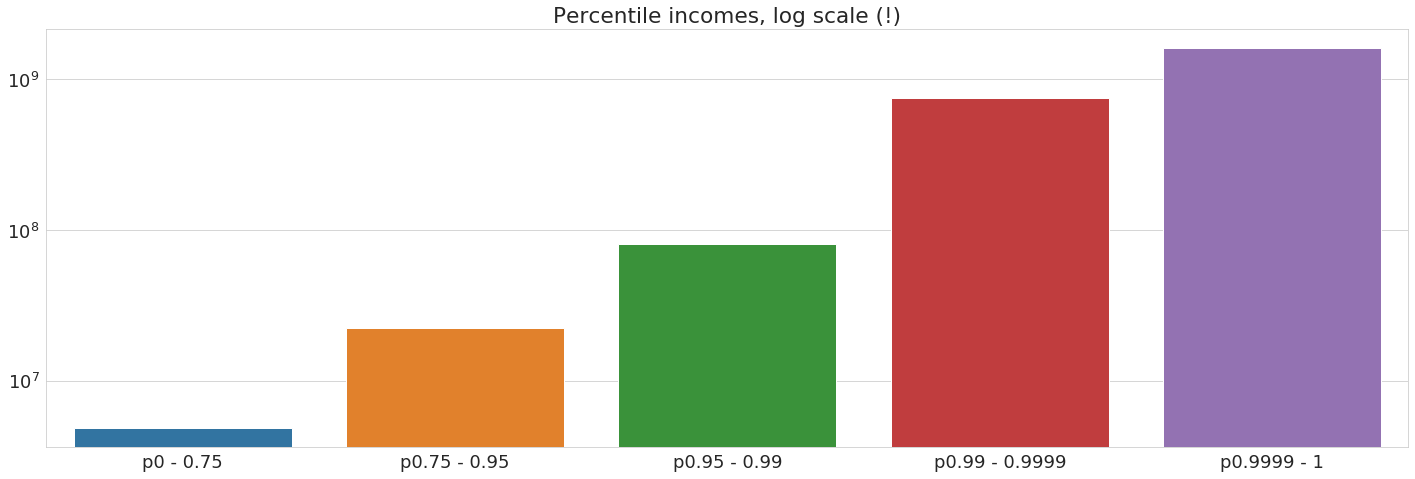

In [483]:
plt.figure(figsize=(20, 7))
plt.title('Percentile incomes, log scale (!)')
sns.barplot(labels, bins[1:])
plt.yscale('log')
save_pic('perc_inc_log')
plt.show()

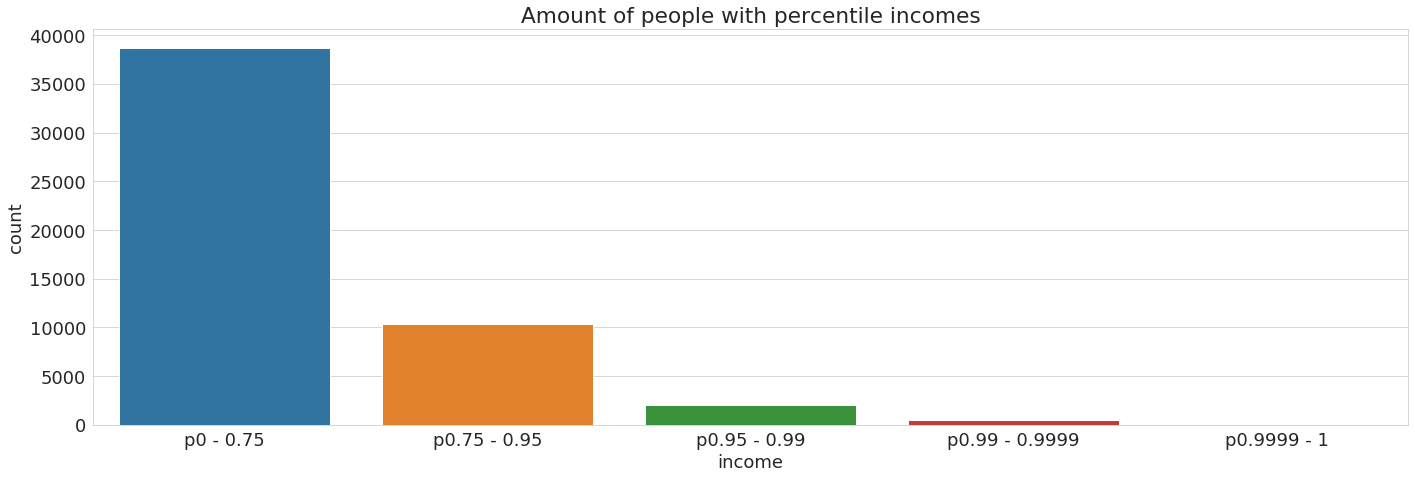

In [484]:
plt.figure(figsize=(20, 7))
plt.title('Amount of people with percentile incomes')
sns.countplot(qcut)
save_pic('perc_am_log')
plt.show()

In [506]:
income_sum.describe()

count    5.165500e+04
mean     6.557713e+06
std      2.147436e+07
min      0.000000e+00
25%      1.321892e+06
50%      2.426111e+06
75%      4.876356e+06
max      1.618558e+09
Name: income, dtype: float64

Total income


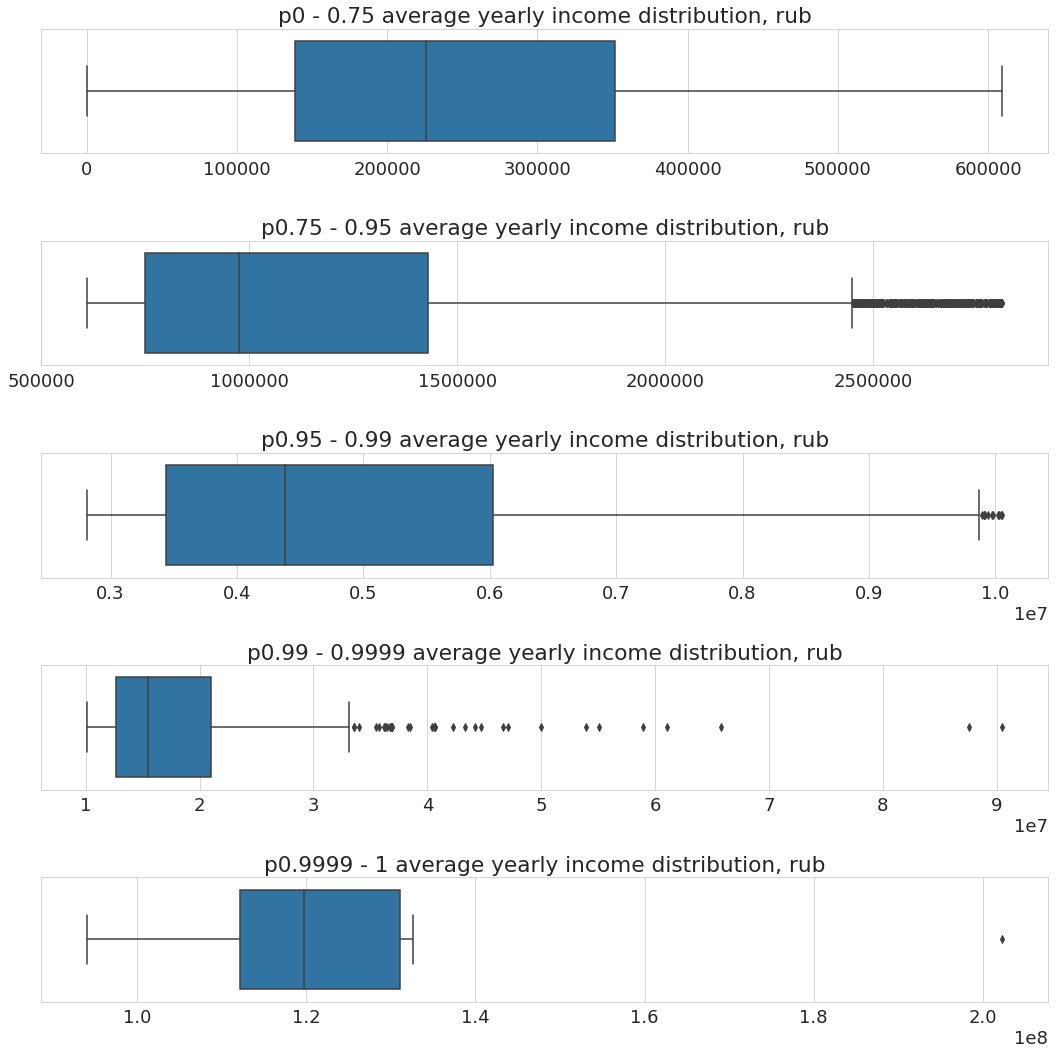

In [508]:
print('Total income')
income_yearly = income_sum / len(years)

plt.figure(figsize=(15, 15))

for i, percentile in enumerate(labels):
    plt.subplot(len(labels), 1, i+1)
    percentile_persons = qcut[qcut == percentile].index
    
    percentile_income = income_yearly.loc[percentile_persons]
    
    plt.title(percentile +' average yearly income distribution, rub')
    millions_xlabel = False
    sns.boxplot(percentile_income, orient='h')
    plt.xlabel('')
save_pic('boxplots_perc')
plt.show()

Total income


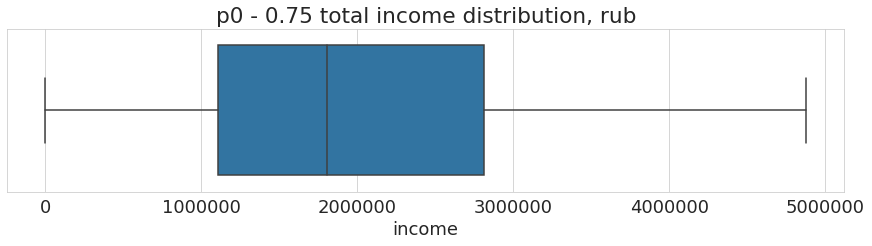

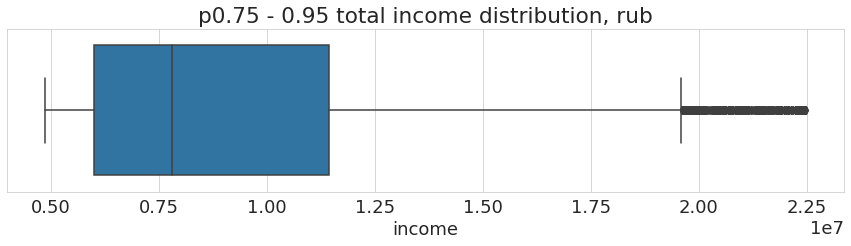

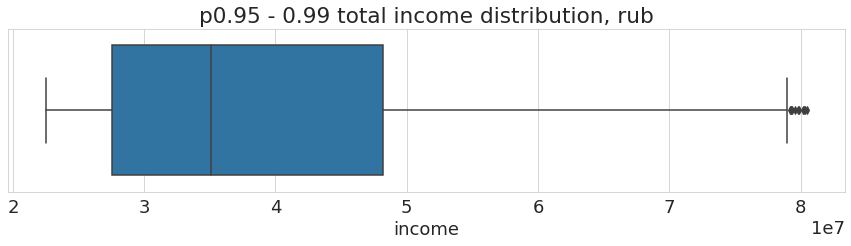

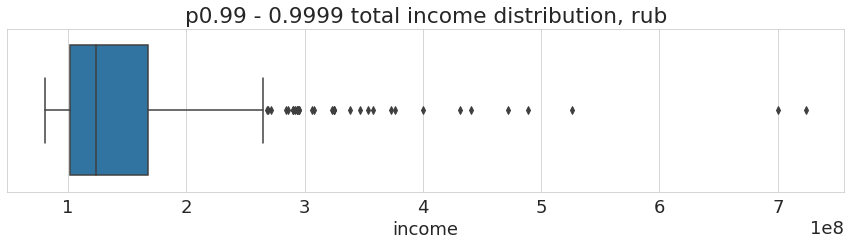

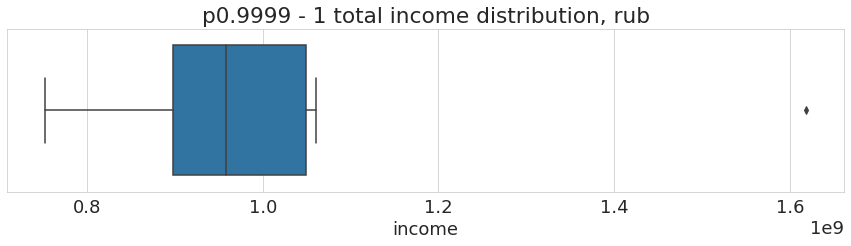

In [503]:
print('Total income')
for percentile in labels:
    percentile_persons = qcut[qcut == percentile].index
    
    percentile_income = income_sum.loc[percentile_persons]
    
    plt.figure(figsize=(15, 3))
    plt.title(percentile +' total income distribution, rub')
    millions_xlabel = False
    sns.boxplot(percentile_income)
    plt.show()

In [487]:
final_df = pd.DataFrame(index=range(1, 11))
for year in declarations_df.year.unique():
    tdf = declarations_df[declarations_df.year == year].groupby(['person_name'])['income'].sum().sort_values(ascending=False)
    top_10 = list(tdf.head(10).index)
    final_df[year] = top_10

print('Top 10 people by income, each year')
final_df

Top 10 people by income, each year


,2009,2010,2011,2012,2013,2014,2015,2016
1,Гребенкин Олег Анатольевич,Медведев Евгений Николаевич,Малкин Виталий Борисович,Ананьев Дмитрий Николаевич,Токарев Николай Петрович,Эфендиев Назим Тофик,Корелин Владимир Владимирович,Пристансков Дмитрий Владимирович
2,Волков Юрий Николаевич,Гребенкин Олег Анатольевич,Милявский Александр Борисович,Гурьев Андрей Григорьевич,Варфоломеев Александр Георгиевич,Сорокин Олег Валентинович,Тихонычева Эльмира Эрнестовна,Панеш Батырбий Мугдинович
3,Зеленин Дмитрий Вадимович,Михеев Олег Леонидович,Бажанов Сергей Викторович,Кононов Владимир Михайлович,Макаров Андрей Михайлович,Шлычков Евгений Иванович,Черкезов Владимир Аванесович,Синяговский Владимир Ильич
4,Лебедев Игорь Владимирович,Туголуков Евгений Александрович,Масловский Павел Алексеевич,Войтова Алла Сергеевна,Бударгин Олег Михайлович,Гозман Константин Маркович,Каноков Арсен Баширович,Грищенко Олег Васильевич
5,Андронов Вадим Вадимович,Борисовец Юрий Львович,Аверин Антон Валерьевич,Бажанов Сергей Викторович,Клишас Андрей Александрович,Гумеров Флун Фагимович,Маркитантов Олег Александрович,Чекотова Нина Алексеевна
6,Исаев Ризвангаджи Абдулаевич,Рожков Игорь Анатольевич,Хамчиев Белан Багаудинович,Клишас Андрей Александрович,Михайлов Сергей Владимирович,Илуров С. Д.,Волков Андрей Александрович,Цехомский Николай Викторович
7,Рейман Леонид Дододжонович,Каноков Арсен Баширович,Сухарев Иван Константинович,Ликсутов Максим Станиславович,Паланкоев Ахмет Магомедович,Лакути Георгий Борисович,Дериглазов Игорь Анатольевич,Смирнов Юрий Валентинович
8,Кацыв Петр Дмитриевич,Зеленин Дмитрий Вадимович,Ананьев Дмитрий Николаевич,Умаханов Умахан Магомедгаджиевич,Морозов Олег Викторович,Терешков Дмитрий Михайлович,Донских Сергей Леонидович,Гольберт Владимир Львович
9,Сурков Владислав Юрьевич,Важенин Юрий Иванович,Живов Вадим Львович,Игошин Андрей Павлович,Исаев Юрий Олегович,Рачков Сергей Геннадьевич,Завальнев Игорь Николаевич,Никифоров Вячеслав Иванович
10,Аристархов Владимир Владимирович,Семёнов Виктор Александрович,Белоусов Вадим Владимирович,Амунц Дмитрий Михайлович,Улюкаев Алексей Валентинович,Акчурин Ильдар Анвярович,Данильченко Юрий Михайлович,Гартунг Валерий Карлович


In [509]:
years_worked = declarations_df.groupby(['person_id'])['year'].nunique()
years_worked.name = 'years worked'
years_worked.head()

person_id
8     8
9     8
10    7
11    4
12    8
Name: years worked, dtype: int64

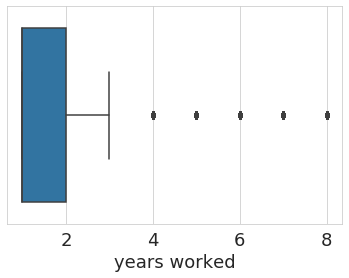

In [510]:
plt.figure()
sns.boxplot(years_worked)
plt.show()

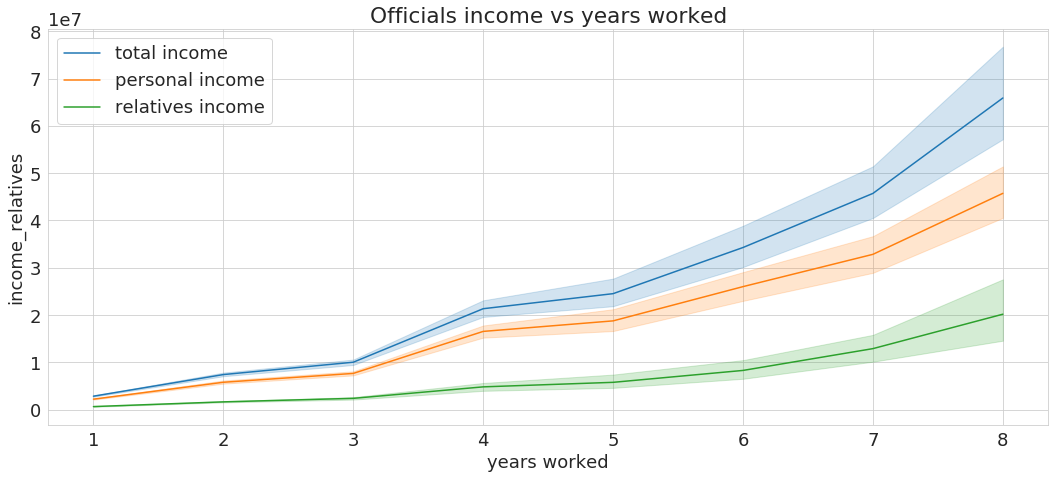

In [511]:
income_df = declarations_df.groupby(['person_id'])['income', 'income_personal', 'income_relatives'].sum()
income_df = income_df.loc[years_worked.index]
plt.figure(figsize=(15, 7))
plt.title('Officials income vs years worked')
sns.lineplot(years_worked, income_df.income, label ='total income')
sns.lineplot(years_worked, income_df.income_personal, label='personal income')
sns.lineplot(years_worked, income_df.income_relatives, label='relatives income')
save_pic('income_vs_years')
plt.show()

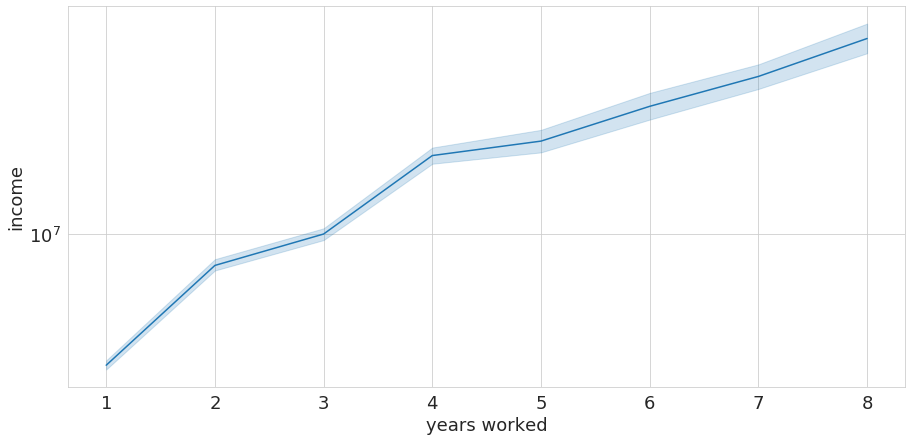

In [512]:
# We can observe a log dependency
plt.figure(figsize=(15, 7))
sns.lineplot(years_worked, income_df.income)
plt.yscale('log')
plt.show()

In [492]:
print('Median', income_df.median())

print('Std', income_df.std())

Median income              2426111.32
income_personal     1884824.65
income_relatives     280950.99
dtype: float64
Std income              2.147436e+07
income_personal     1.735044e+07
income_relatives    9.001129e+06
dtype: float64


In [493]:
# Income change
# Latest income vs centrality
# 
yearly_income = declarations_df[(declarations_df.year >= 2013) &
                                            (declarations_df.year <= 2016)].groupby(['person_id', 'year'])[['income', 'income_personal', 'income_relatives']].sum().reset_index()
print(yearly_income.shape)
yearly_income.head()

(75502, 5)


,person_id,year,income,income_personal,income_relatives
0,8,2013,3392882.89,3194615.67,198267.22
1,8,2014,4650875.15,4460788.41,190086.74
2,8,2015,6722705.23,6538890.04,183815.19
3,8,2016,5686755.42,5499187.78,187567.64
4,9,2013,18133519.25,16647820.37,1485698.88


In [494]:
years_count = yearly_income.reset_index().groupby(['person_id'])['year'].count().reset_index()
years_count.head()

,person_id,year
0,8,4
1,9,4
2,10,3
3,12,4
4,13,4


In [495]:
# Remove those that haven't worked for 4 years
yearly_income = yearly_income[yearly_income.person_id.isin(years_count[years_count.year >= 2].person_id)]
yearly_income.shape

(45931, 5)

In [496]:
max_years = yearly_income.groupby(['person_id'])['year'].idxmax()
max_incomes = yearly_income.loc[max_years]
max_incomes.index = max_incomes.person_id
max_incomes.head()

,person_id,year,income,income_personal,income_relatives
person_id,,,,,
8,8,2016,5686755.42,5499187.78,187567.64
9,9,2016,25168247.27,21877770.76,3290476.51
10,10,2015,5775076.27,4875905.09,899171.18
12,12,2016,8025912.94,5641096.59,2384816.35
13,13,2016,5736078.02,5349746.68,386331.34


In [497]:
min_years = yearly_income.groupby(['person_id'])['year'].idxmin()
min_incomes = yearly_income.loc[min_years]
min_incomes.index = max_incomes.person_id
min_incomes.head()

,person_id,year,income,income_personal,income_relatives
person_id,,,,,
8,8,2013,3392882.89,3194615.67,198267.22
9,9,2013,18133519.25,16647820.37,1485698.88
10,10,2013,4368530.71,3655249.56,713281.15
12,12,2013,2802081.80,2541317.22,260764.58
13,13,2013,3263364.19,2943197.15,320167.04


In [498]:
income_change = max_incomes['income'] - min_incomes['income']
income_change.head()

person_id
8     2293872.53
9     7034728.02
10    1406545.56
12    5223831.14
13    2472713.83
Name: income, dtype: float64

In [499]:
income_change = income_change[income_change.between(income_change.quantile(.5),
                                                    income_change.quantile(.95))]
income_change.shape

(8667,)

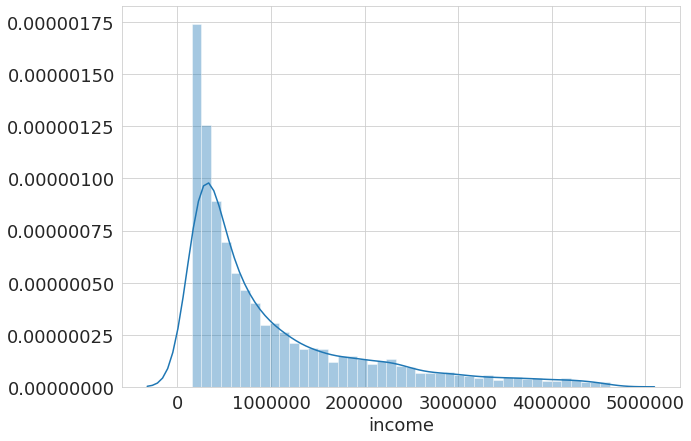

In [500]:
plt.figure(figsize=(10, 7))
sns.distplot(income_change)
plt.show()

In [501]:
# Scratch area below

degree
(8581, 3)
Pearson:
(0.038339411472402, 0.0003818652253687768)
Spearman:
SpearmanrResult(correlation=-0.013766629898210658, pvalue=0.2022638243789769)



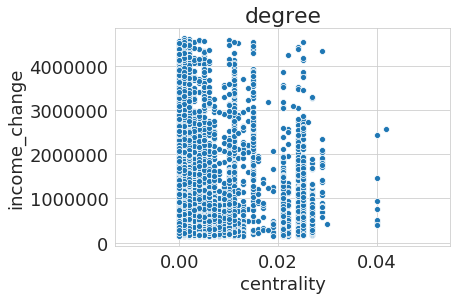

betweenness
(8581, 3)
Pearson:
(0.03190684675380296, 0.0031168655653423753)
Spearman:
SpearmanrResult(correlation=0.02118293361613884, pvalue=0.04974065500725741)



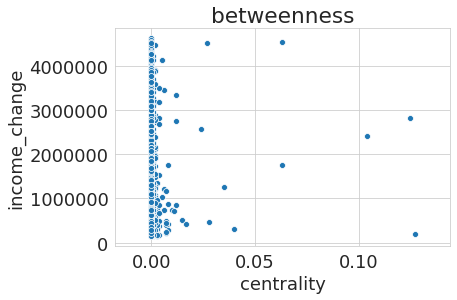

closeness
(8577, 3)
Pearson:
(-0.014243759380553753, 0.18716275061173304)
Spearman:
SpearmanrResult(correlation=0.12528918096102773, pvalue=2.362265051294769e-31)



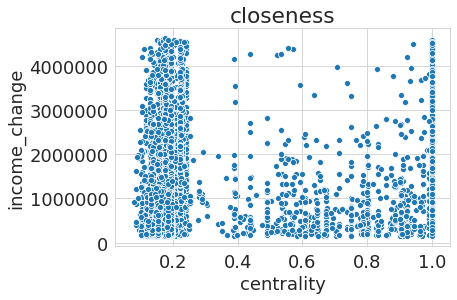

In [502]:
import json
centralities = ['degree', 'betweenness', 'closeness']
for cname in centralities:
    with open(f'data/{cname}_centrality.json') as f:
        jsondata = json.loads(f.read())
        centrality = pd.DataFrame(jsondata.items())
    centrality.columns = ['person_id', 'centrality']
    centrality['person_id'] = centrality['person_id'].astype(int)
    centrality.index = centrality.person_id
    centrality['income_change'] = income_change
    centrality = centrality.dropna()
    print(cname)
    print(centrality.shape)
    print('Pearson:')
    print(scipy.stats.pearsonr(centrality.income_change, centrality.centrality))
    print('Spearman:')
    print(scipy.stats.spearmanr(centrality.income_change, centrality.centrality))
    print('')
    
    plt.figure()
    sns.scatterplot(y=centrality.income_change, x=centrality.centrality)
    plt.title(cname)
    plt.show()